In [1]:
from numpy import*
from pylab import*
import matplotlib.pyplot as plt
from h5py import File
import pandas as pd
from slab.dsfit import*
from slab import*
import json
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from qutip import *

Warning could not load Chase AWG dll, check that dll located at 'C:\_Lib\python\slab\instruments\awg\chase\dax22000_lib_DLL32.dll'


C:\Users\slab\Anaconda3\lib\site-packages\IPython\qt.py:13: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  "You should import from qtconsole instead.", ShimWarning)


Could not load InstrumentManagerWindow
Warning could not load LDA labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_atten.dll'
Warning could not load LMS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\vnx_fmsynth.dll'
Warning could not load LPS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_dps.dll'
Could not load labbrick


# Fit functions

In [2]:
def coherent_state(n, alpha):
    return exp(-abs(alpha)**2)*abs(alpha)**(2*n)/scipy.special.factorial(n)

def line(x, m, b):
    return m*x+b

def proportional(x, m):
    return m * x

def gfromchi(chi,alpha,delta):
    return sqrt(chi*delta*(delta+alpha)/alpha)

def gaussfuncsum(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    return y

def gaussfuncsum_with_baseline(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    y += p[0]
    return y

def fitgausssum(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label="",debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:
        fitparams=0*ones(3*N+1)
        fitparams[0]=(fitdatay[0]+fitdatay[-1])/2.
        fitparams[1]=max(fitdatay)-min(fitdatay)
        fitparams[2]=fitdatax[np.argmax(fitdatay)]
        fitparams[3]=(max(fitdatax)-min(fitdatax))/10.
    if debug==True: print(fitparams)
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    p1[3]=abs(p1[3])
    return p1

def fitgausssum_with_baseline(xdata,ydata,fitparams=None,domain=None,showfit=False,
                              showstartfit=False,label="",debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:
        fitparams=0*ones(3*N+1)
        fitparams[0]=(fitdatay[0]+fitdatay[-1])/2.
        fitparams[1]=max(fitdatay)-min(fitdatay)
        fitparams[2]=fitdatax[np.argmax(fitdatay)]
        fitparams[3]=(max(fitdatax)-min(fitdatax))/10.
    if debug==True: print(fitparams)
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum_with_baseline, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    p1[3]=abs(p1[3])
    return p1

def expfunc2(p,x):
    """p[0]+p[1]*exp(-(x-p[2])/p[3])"""
    return p[0]*math.e**(-(x-p[1])/p[2])

def fitexp2(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label=""):
    """Fit exponential decay (p[0]*exp(-(x-p[1])/p[2]))"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:    
        fitparams=[0.,0.,0.,0.]
        fitparams[0]=fitdatay[0]-fitdatay[-1]
        fitparams[1]=fitdatax[0]
        fitparams[2]=(fitdatax[-1]-fitdatax[0])/5.
    #print fitparams
    p1 = fitgeneral(fitdatax, fitdatay, expfunc2, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    return p1   

def expfunc_test(x, b,c):
    return b * math.e**(-x/c)

def expfunc_baseline(x, a, b, c):
    return a*np.exp(-x/b) + c

def doublegauss(bins, *p):
    a1, sigma1, mu1 = p[0], p[1], p[2]
    a2, sigma2, mu2 = p[3], p[4], p[5]

    y1 = a1*((1 / (np.sqrt(2 * np.pi) * sigma1)) *
     np.exp(-0.5 * (1 / sigma1 * (bins - mu1))**2))
    y2 = a2*((1 / (np.sqrt(2 * np.pi) * sigma2)) *
     np.exp(-0.5 * (1 / sigma2 * (bins - mu2))**2))
    y = y1+y2
    
    return y
def gaussian2d(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)


def hist(filename=None, data=None, plot=True, ran=1.0):
    
    if data == None:
        with File(filename,'r') as a:
            ig = array(a['ig'])
            qg = array(a['qg'])
            ie = array(a['ie'])
            qe = array(a['qe'])
            a.close()
    else:
        ig = data[0]
        qg = data[1]
        ie = data[2]
        qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*')
        axs[0].scatter(ie, qe, label='e', color='r', marker='*')
        axs[0].scatter(xg, yg, color='k', marker='o')
        axs[0].scatter(xe, ye, color='k', marker='o')
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -arctan((ye-yg)/(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*cos(theta) - qg*sin(theta)
    qg_new = ig*sin(theta) + qg*cos(theta) 
    ie_new = ie*cos(theta) - qe*sin(theta)
    qe_new = ie*sin(theta) + qe*cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)

    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='upper right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
    #     popt, pcov = curve_fit(doublegauss, xdata=binsg[:-1], ydata=ng, p0=p0)
    #     mu_g = popt[2]
    #     axs[2].plot(binsg, doublegauss(binsg, *popt), 'k--', linewidth=2 )
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
    #     popt, pcov = curve_fit(doublegauss, xdata=binse[:-1], ydata=ne, p0=p0)
    #     mu_e = popt[5]
    #     axs[2].plot(binse, doublegauss(binse, *popt), 'k--', linewidth=2 )
    #     axs[2].text(0.5*(mu_g + mu_e), 0.3*np.max(ne), "$\mu_{g}$ = %.4f \n $\mu_{e}$ = %.4f"%(mu_g, mu_e), fontsize=16)

        axs[2].set_xlabel('I(a.u.)')        
        fig.show()
        
    else:        
        ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
        ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum()))).max()

    return fid, theta

def rot_data(i, q, hist_filename=None):
    
    fid, theta = hist(hist_filename)
    print(fid, theta)
    """Rotate the IQ data"""
    i_new = i*cos(theta) - q*sin(theta)
    q_new = i*sin(theta) + q*cos(theta) 
    
    return (i_new, q_new)


def ramsfit(tR, n0, phi0, a):
    T2 = 120e-6
    dephase = 1/T2
    detune = 2*np.pi*1e6 
    chi = 2*np.pi*380e3
    kappa = 2*np.pi*(8.0517e9)/8800
    tau = []
    z = []
    res = []
    for i,t in enumerate(tR):
        tau.append((1-np.exp(-complex(kappa*tR[i], 2*chi*tR[i])))/complex(kappa, 2*chi))
        z.append(np.exp(complex(-dephase*tR[i] , phi0 - detune*tR[i] - 2*n0*chi*tau[i])))
        res.append(a*0.5*(1-np.imag(z[i])))
    return np.array(res)

# Resonator spectroscopy

fits =  [-7.22626340e-07  7.37545529e-04  8.05183773e+00  4.77002479e-04]
fits =  [-1.41457670e-04  2.26328446e-02  8.05180971e+00  4.67196842e-04]
fits =  [-2.30146159e-04  3.25613203e-02  8.05181984e+00  4.71579874e-04]
fits =  [-4.14391884e-07  5.10003935e-05  8.05184642e+00  4.70974157e-04]


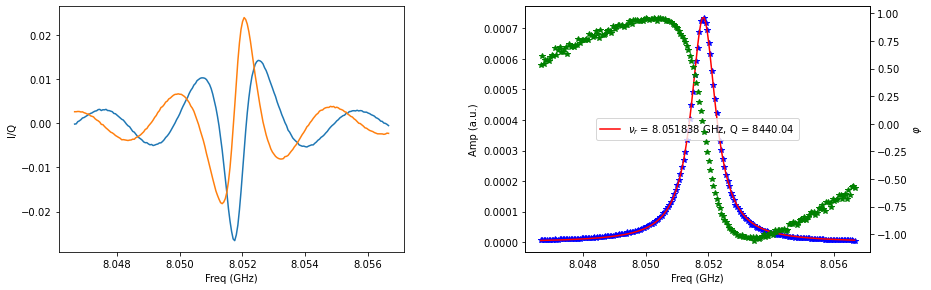

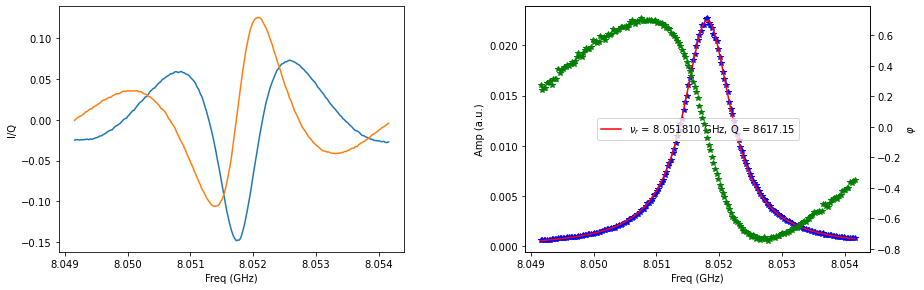

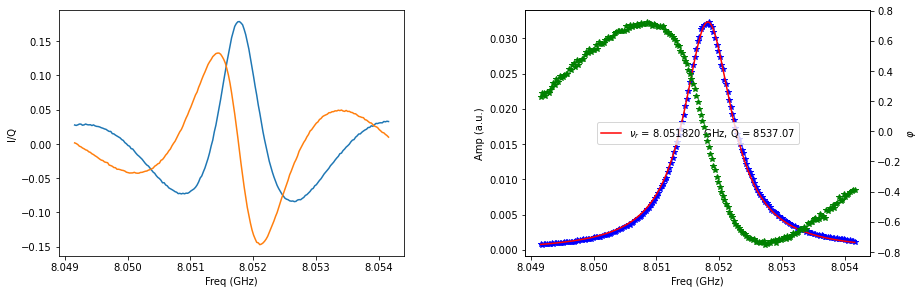

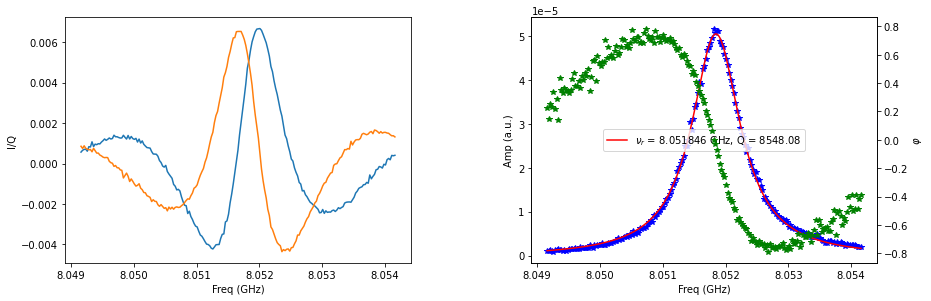

In [92]:
expt_name = 'resonator_spec'
filelist = [0, 21, 22, 24]
#3 - amp(0.5)
#4 - 8us long readout

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['freqs'])/1e9
        a.close()
        
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.35)
    axs[0].plot(x, I)
    axs[0].plot(x, Q)
    axs[0].set_xlabel('Freq (GHz)')
    axs[0].set_ylabel('I/Q')
#     amps = np.sqrt(I**2 + Q**2)
    amps = Q**2 + I**2
    ph = np.arctan2(np.array(Q), np.array(I))
    ph = np.unwrap(ph, discont=3.141592653589793, axis=-1)
    m = (ph[-1]-ph[0])/(x[-1] - x[0])
    ph = ph - m*x*0.95
    ph = ph -np.mean(ph)
    axs[1].plot(x, amps, 'b*')
    p = fitlor(x, amps, showfit=False)
    q = p[2]/(2*p[3])
    axs[1].plot(x, lorfunc(p, x), label=r'$\nu_{r}$ = %.6f GHz, Q = %.2f'% (p[2], q), color='r')
    print ("fits = ", p)
    ax2  = axs[1].twinx()
    ax2.plot(x, ph, 'g*')
    axs[1].set_xlabel('Freq (GHz)')
    axs[1].set_ylabel('Amp (a.u.)')
    ax2.set_ylabel('$\\varphi$')
    axs[1].legend(loc='center')

# Resonator Chi

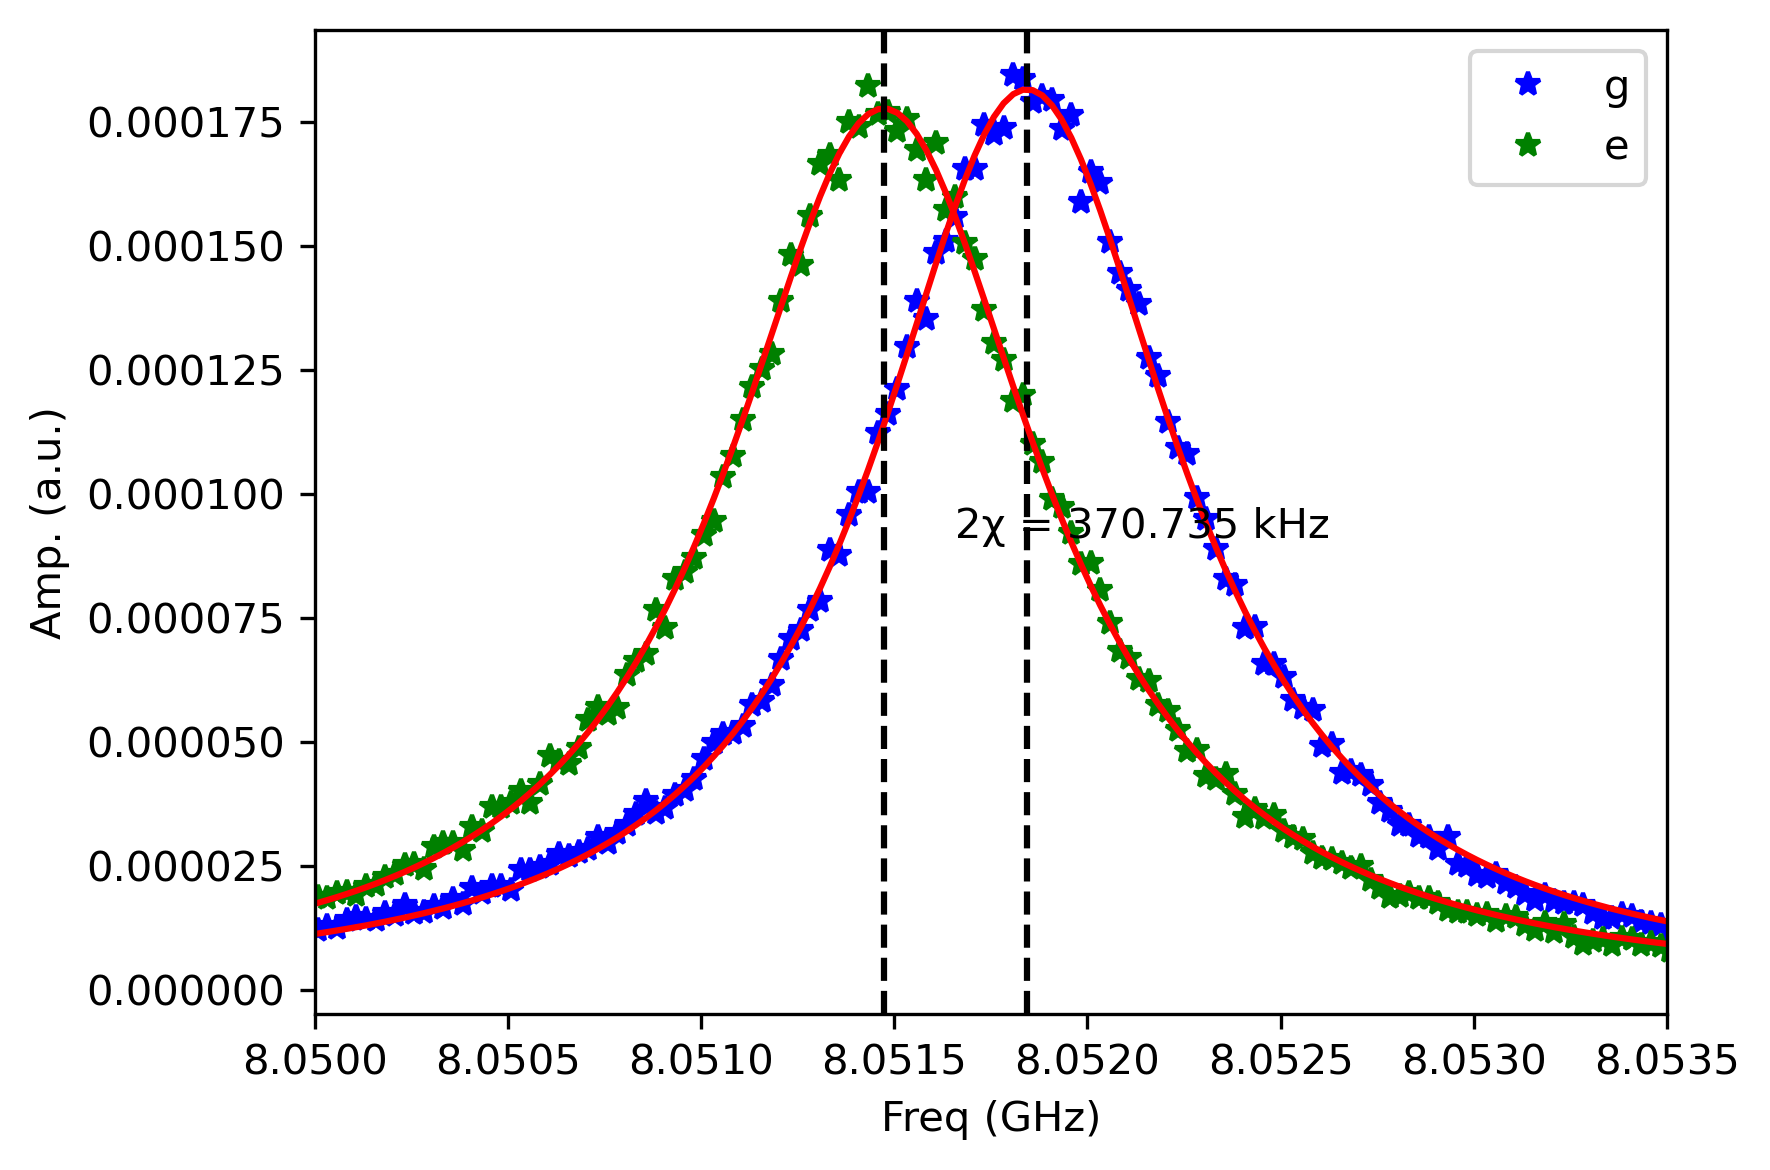

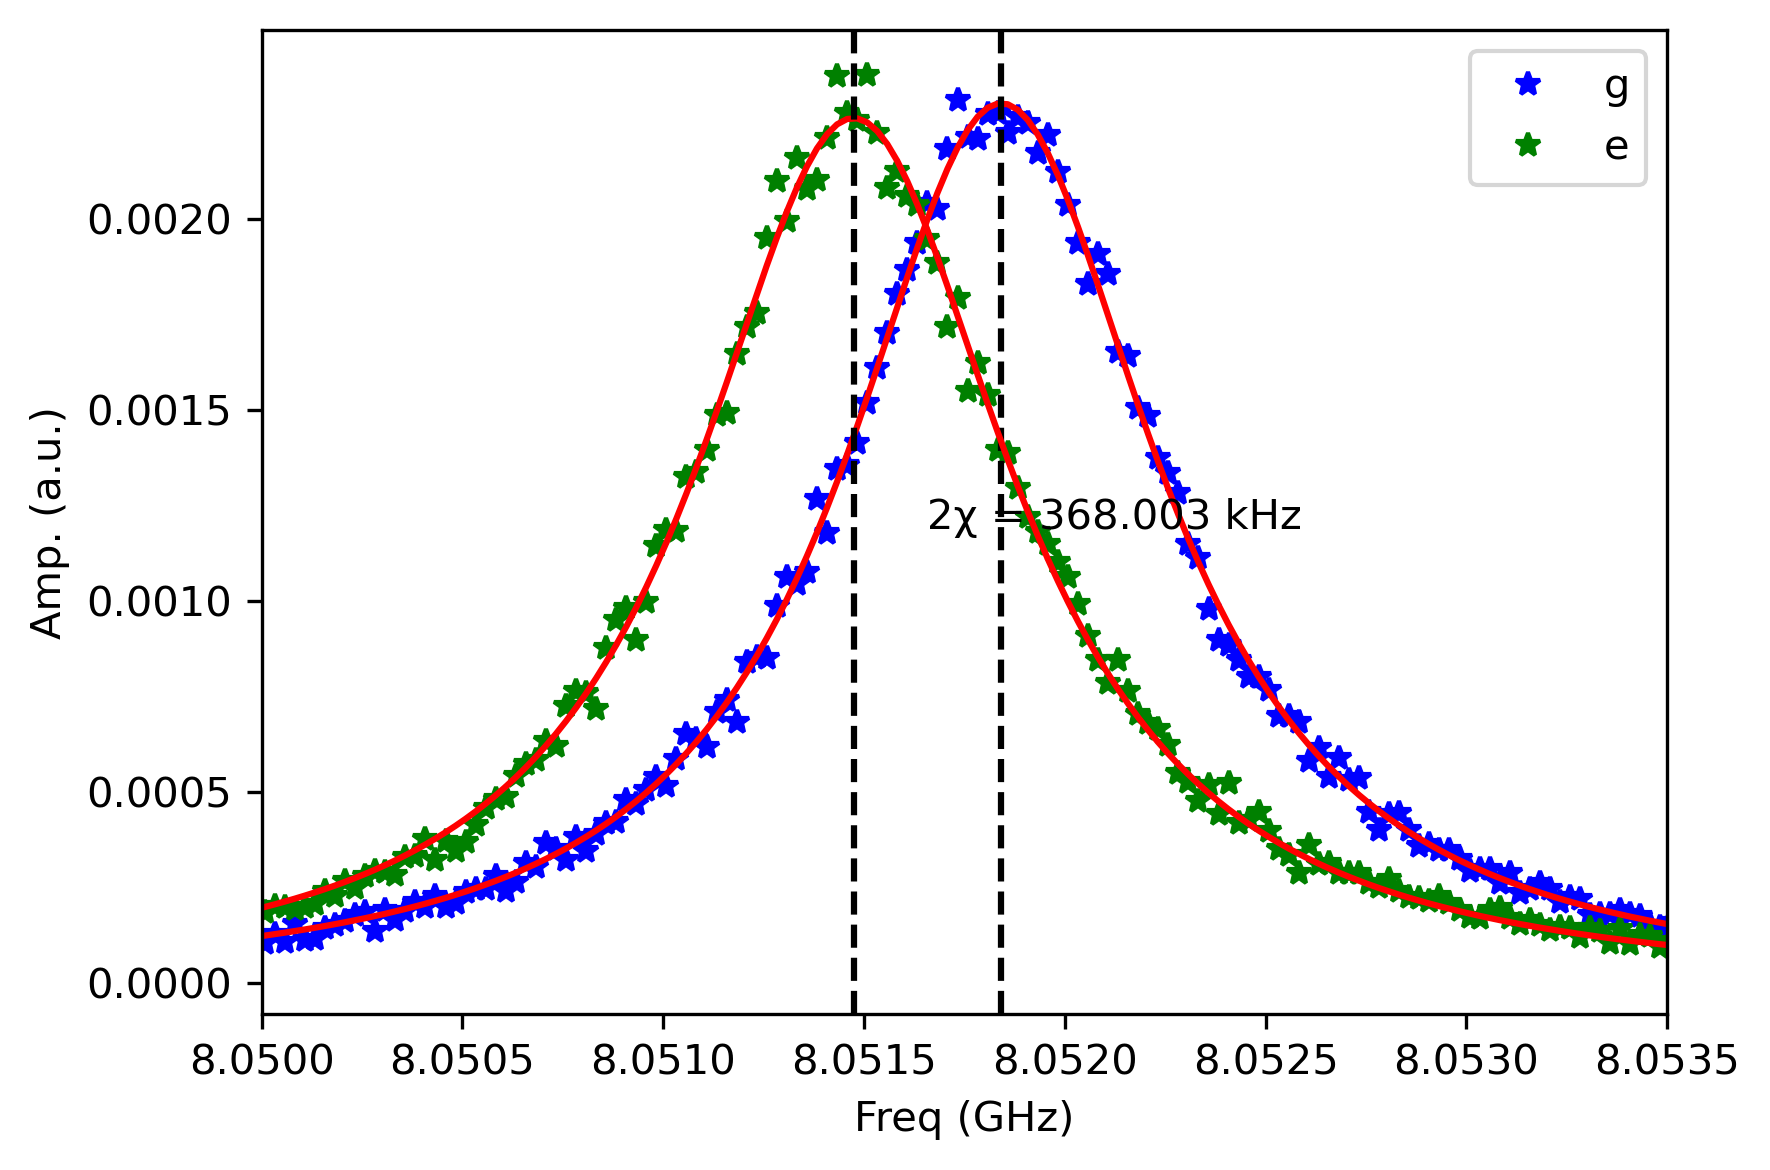

In [73]:
expt_name = 'resonator_chi'
filelist = [2, 7]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        ig = np.array(a['Ig']) 
        qg = np.array(a['Qg']) 
        ie = np.array(a['Ie']) 
        qe = np.array(a['Qe']) 
        freq = np.array(a["freqs"]) 
        a.close()

    amps_g = (ig**2 + qg**2)
    amps_e = (ie**2 + qe**2)
    f = np.array(freq/1e9)

    fig, ax1 = plt.subplots(1, 1, dpi=300)
    ax1.plot(f, amps_g, 'b*', label='g')
    ax1.plot(f, amps_e, 'g*', label='e')
    ax1.set_xlim(8.05, 8.0535)
    pg = fitlor(f, amps_g, showfit=False)
    ax1.plot(f, lorfunc(pg, f), 'r')
    plt.axvline(x=pg[2], color='k', linestyle='--')
    pe = fitlor(f, amps_e, showfit=False)
    ax1.plot(f, lorfunc(pe, f), 'r')
    plt.axvline(x=pe[2], color='k', linestyle='--')
    chi = (pg[2]-pe[2])*1e6
    plt.text(np.mean(f), np.max(amps_e)*0.5, '2χ = %.3f kHz'%chi)
    plt.legend(loc='best')
    plt.xlabel('Freq (GHz)')
    plt.ylabel('Amp. (a.u.)')
    fig.tight_layout()
#     plt.savefig('../plots/readout_chi.png', dpi=300)
    plt.show()

In [348]:
(pg[2], pe[2])

(8.051842009148418, 8.051474006493713)

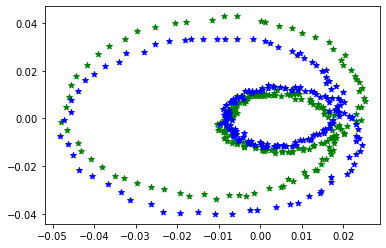

In [77]:
plt.scatter(ig, qg, color='g', marker='*')
plt.scatter(ie, qe, color='b', marker='*')

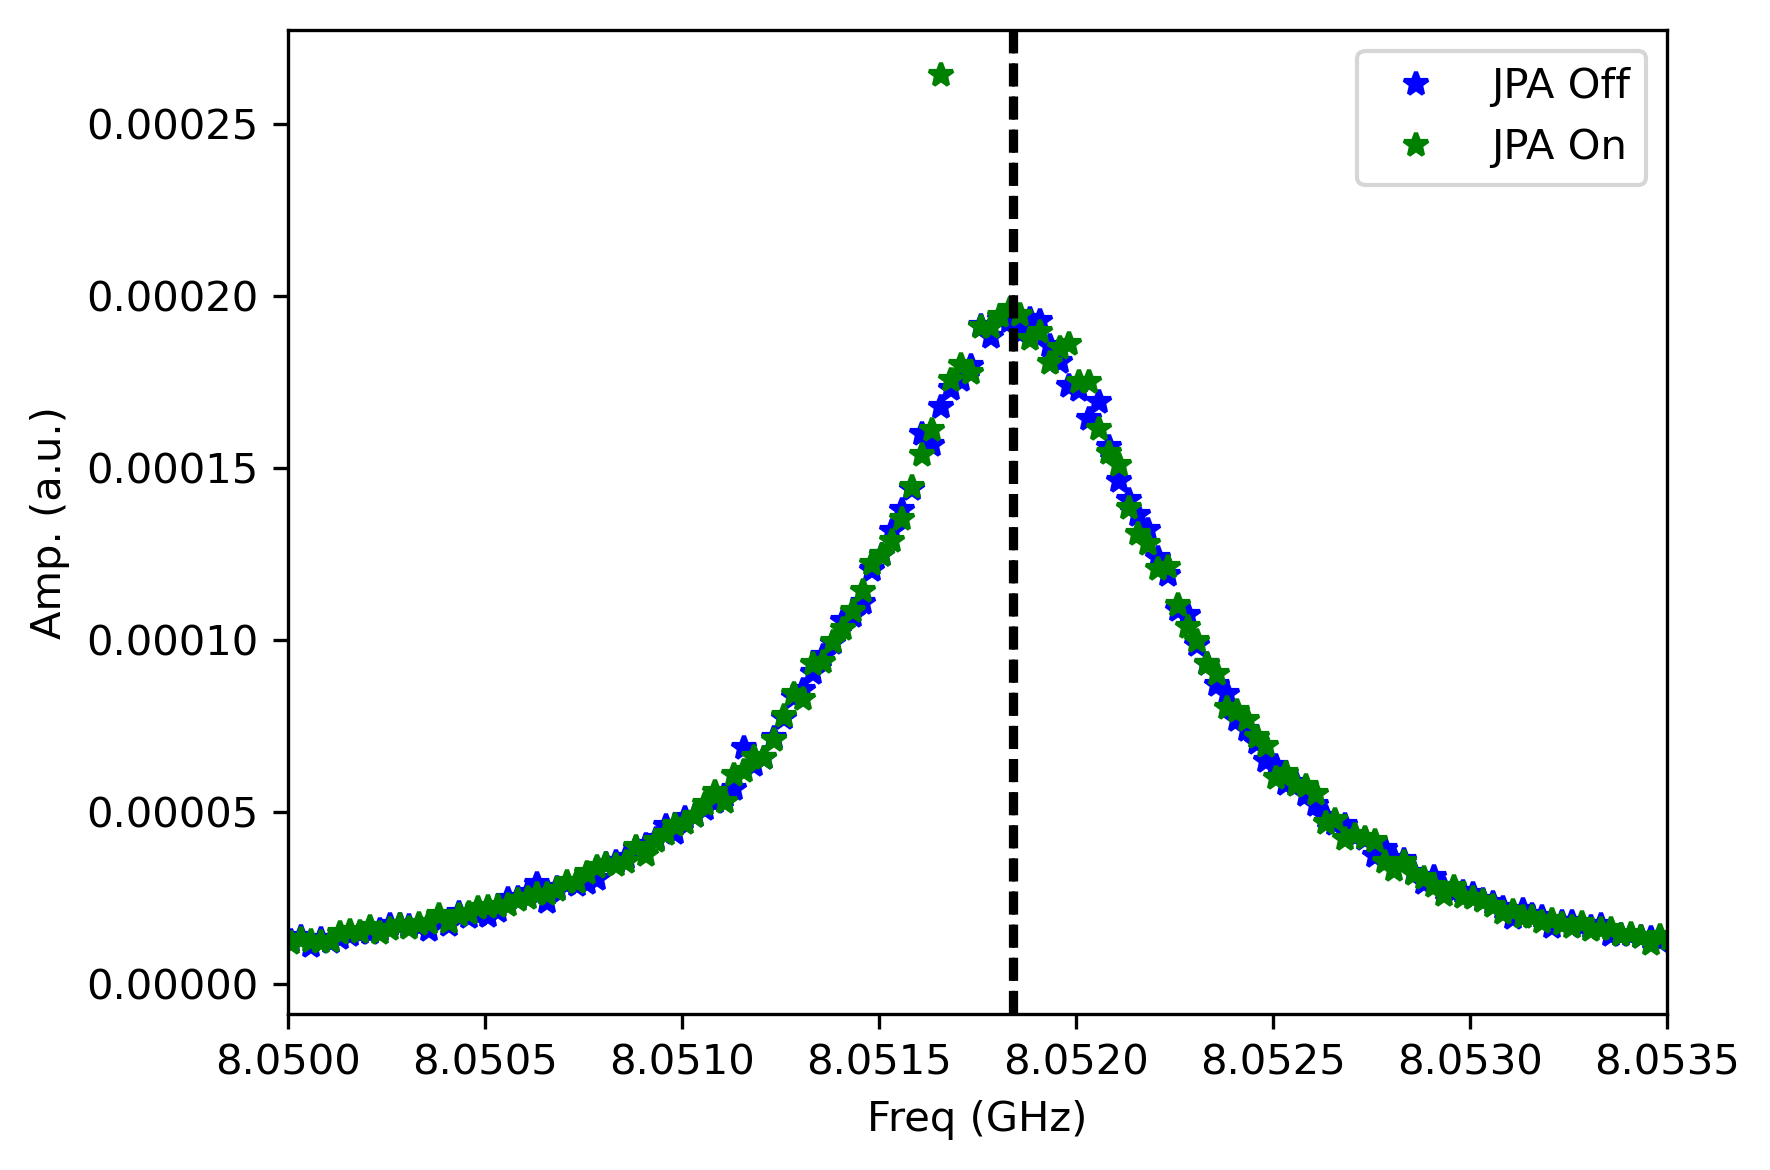

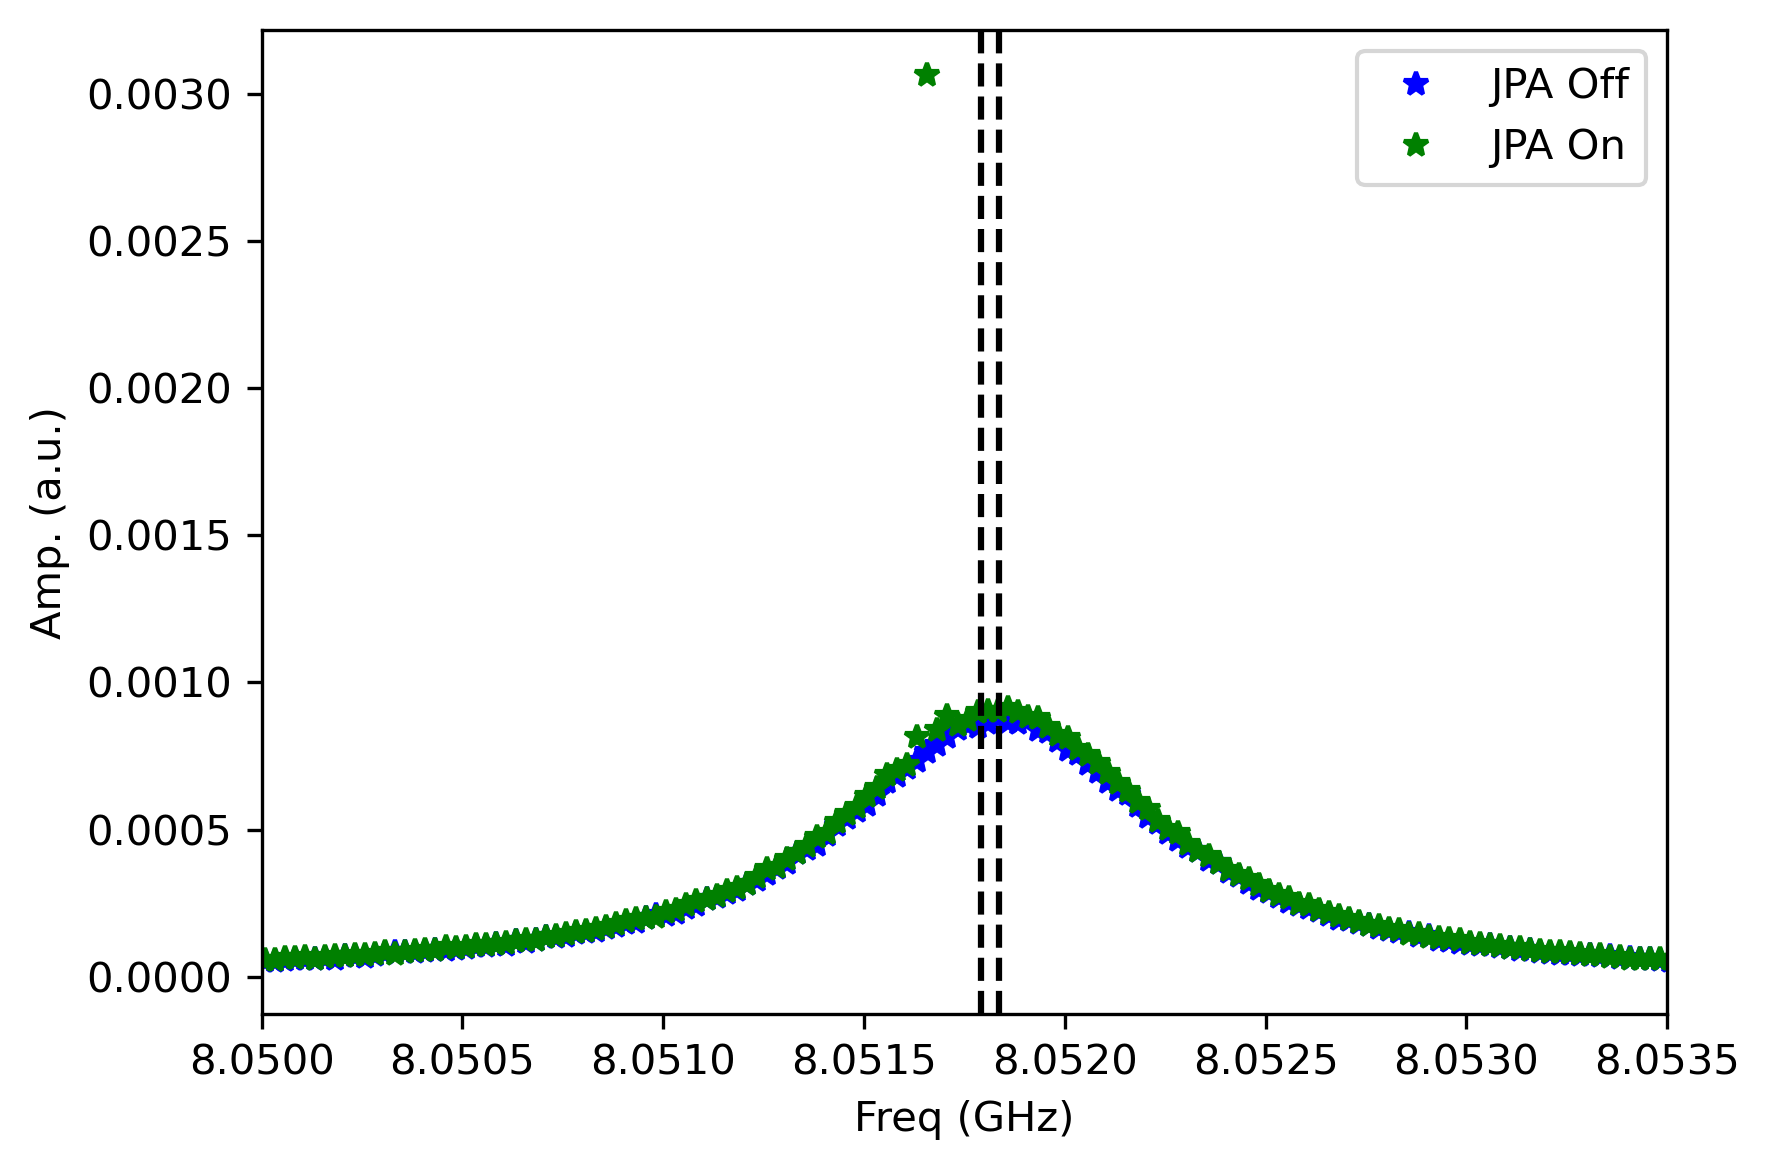

In [180]:
expt_name = 'resonator_jpa'
filelist = [0, 14]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        ig = np.array(a['Ig']) 
        qg = np.array(a['Qg']) 
        ie = np.array(a['Ie']) 
        qe = np.array(a['Qe']) 
        freq = np.array(a["freqs"]) 
        a.close()

    amps_g = (ig**2 + qg**2)
    amps_e = (ie**2 + qe**2)
    f = np.array(freq/1e9)

    fig, ax1 = plt.subplots(1, 1, dpi=300)
    ax1.plot(f, amps_g, 'b*', label='JPA Off')
    ax1.plot(f, amps_e, 'g*', label='JPA On')
    ax1.set_xlim(8.05, 8.0535)
    pg = fitlor(f, amps_g, showfit=False)
#     ax1.plot(f, lorfunc(pg, f), 'r')
    plt.axvline(x=pg[2], color='k', linestyle='--')
    pe = fitlor(f, amps_e, showfit=False)
#     ax1.plot(f, lorfunc(pe, f), 'r')
    plt.axvline(x=pe[2], color='k', linestyle='--')
    chi = (pg[2]-pe[2])*1e6
#     plt.text(np.mean(f), np.max(amps_e)*0.5, '2χ = %.3f kHz'%chi)
    plt.legend(loc='best')
    plt.xlabel('Freq (GHz)')
    plt.ylabel('Amp. (a.u.)')
#     plt.ylim(0, 25e-5)
    fig.tight_layout()
#     plt.savefig('../plots/readout_chi.png', dpi=300)
    plt.show()

In [18]:
pg[2]/(2*pg[3])

8361.458917615915

# Qubit ge spectroscopy

fits =  [-2.53528334e-02  1.81586693e-03  4.74691305e+00  8.98604266e-04]
fits =  [-1.57797342e-02  1.26241619e-03  4.74698538e+00  9.49786917e-04]
fits =  [-9.90813504e-02  8.44390710e-03  4.74692512e+00  9.52410759e-04]


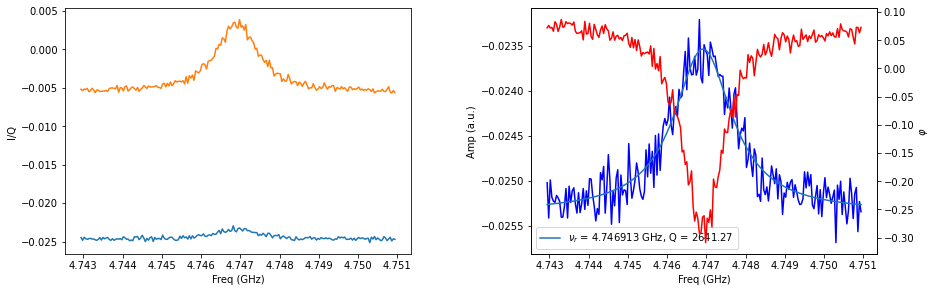

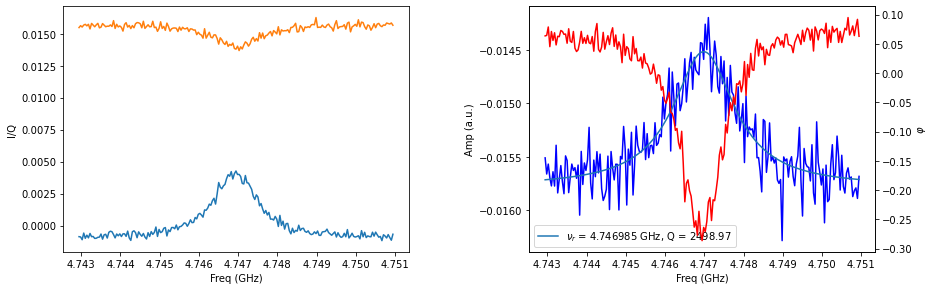

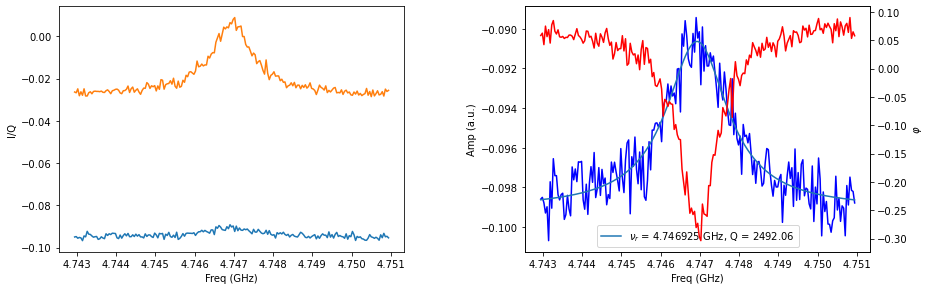

In [64]:
expt_name = 'ge_spectroscopy'
filelist = [0, 1, 7]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['freqs'])/1e9
        a.close()
        
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.35)
    axs[0].plot(x, I)
    axs[0].plot(x, Q)
    axs[0].set_xlabel('Freq (GHz)')
    axs[0].set_ylabel('I/Q')
    amps = -np.sqrt(np.array(I)**2 + 1*np.array(Q)**2)
#     amps = Q
    ph = np.arctan2(np.array(Q), np.array(I))
    ph = np.unwrap(ph, discont=3.141592653589793, axis=-1)
    m = (ph[-1]-ph[0])/(x[-1] - x[0])
    ph = ph - m*x*0.95
    ph = ph -np.mean(ph)
    axs[1].plot(x, amps, 'b-')
    p = fitlor(x, amps, showfit=False)
    q = p[2]/(2*p[3])
    axs[1].plot(x, lorfunc(p, x), label=r'$\nu_{r}$ = %.6f GHz, Q = %.2f'% (p[2], q))
    print ("fits = ", p)
    ax2  = axs[1].twinx()
    ax2.plot(x, ph, 'r-')
    axs[1].set_xlabel('Freq (GHz)')
    axs[1].set_ylabel('Amp (a.u.)')
    ax2.set_ylabel('$\\varphi$')
    axs[1].legend(loc='best')

# Ramsey

Original qubit frequency choice = 4.746942812186551 GHz
Oscillation freq =  0.0989423086014202  MHz
Offset freq = 0.0010576913985798075 MHz
Suggested qubit frequency choice = 4.746943869877949 GHz
T2* = 117.02825247568352 us
Original qubit frequency choice = 4.746943660718653 GHz
Oscillation freq =  0.09905879291075721  MHz
Offset freq = 0.0009412070892427932 MHz
Suggested qubit frequency choice = 4.746944601925742 GHz
T2* = 128.53845261335428 us
Original qubit frequency choice = 4.746943660718653 GHz
Oscillation freq =  0.10209976361086516  MHz
Offset freq = -0.0020997636108651546 MHz
Suggested qubit frequency choice = 4.746941560955042 GHz
T2* = 123.04141311812003 us


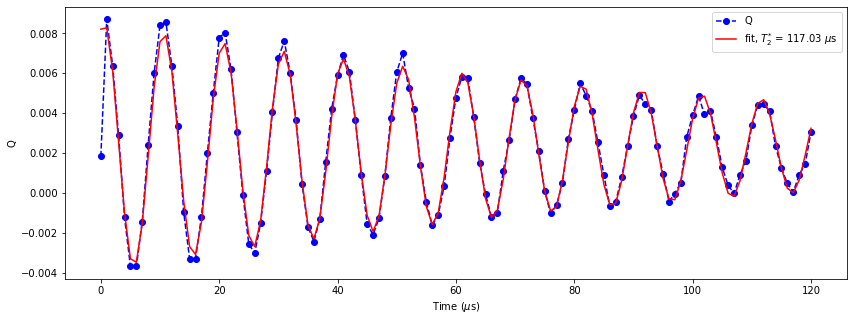

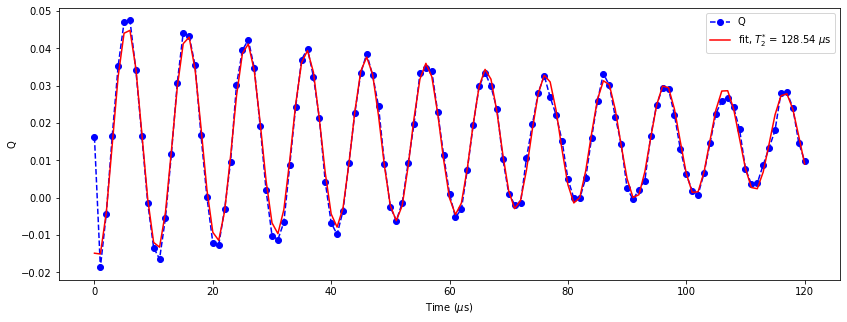

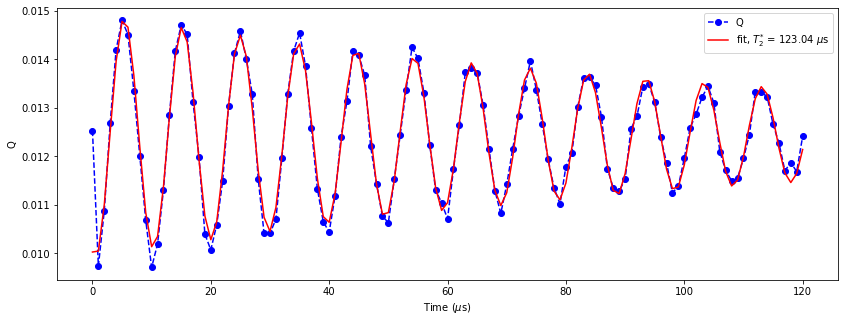

In [116]:
expt_name = 'Ramsey'
filelist = [0, 22, 23]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        t = array(a['time'])
        ramsey_freq = array(a['ramsey_freq'])/1e6
        qubit_freq = array(a['qubit_freq'])/1e9
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        P = Q
        p = fitdecaysin(t[:], P[:],fitparams = None, showfit=False)
        ax.plot(t, P, 'bo--',label = 'Q')
        ax.plot(t[:], decaysin(np.append(p, 0), t[:]), 'r-', label=r'fit, $T_{2}^{*}$ = %.2f $\mu$s' % p[3])
        offset = ramsey_freq - p[1]
        nu_q_new = qubit_freq + offset/1e3
        print("Original qubit frequency choice =", qubit_freq,"GHz")
        print ("Oscillation freq = ", p[1]," MHz")
        print("Offset freq =", offset,"MHz")
        print("Suggested qubit frequency choice =", nu_q_new,"GHz")
        print("T2* =", p[3],"us")
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel('Q')
        ax.legend()

# Ramsey Phase

Original qubit frequency choice = 4.746943660718653 GHz
Oscillation freq =  0.3996883286019847  MHz
Offset freq = 0.10031167139801528 MHz
Suggested qubit frequency choice = 4.747043972390051 GHz
T2* = 134.57093190950116 us
Original qubit frequency choice = 4.746943660718653 GHz
Oscillation freq =  0.00014734550780345955  MHz
Offset freq = 0.09985265449219655 MHz
Suggested qubit frequency choice = 4.7470435133731455 GHz
T2* = 28.594193201473463 us
Original qubit frequency choice = 4.746943660718653 GHz
Oscillation freq =  0.3171477809697032  MHz
Offset freq = -0.2171477809697032 MHz
Suggested qubit frequency choice = 4.746726512937683 GHz
T2* = 132.56492866020224 us


C:\Users\slab\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


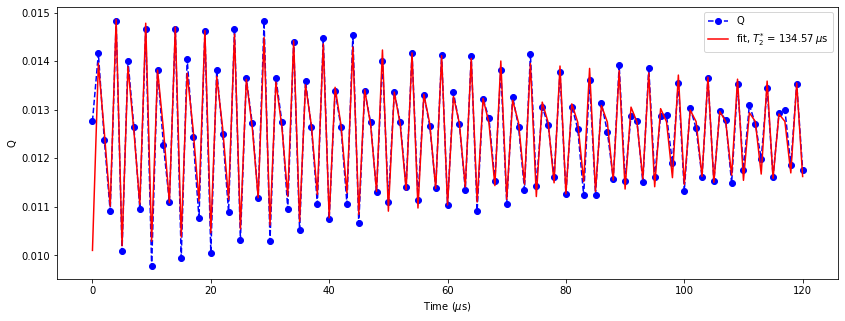

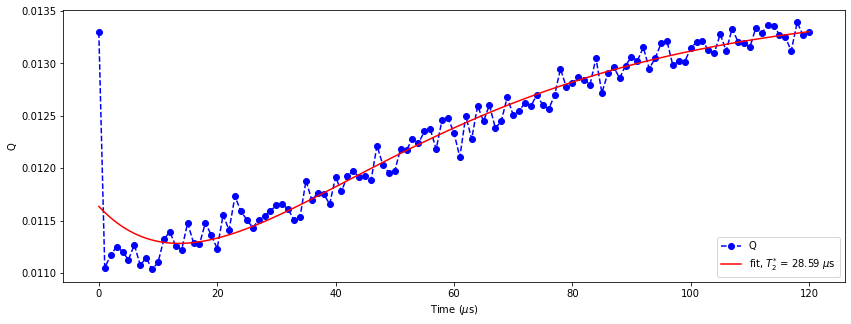

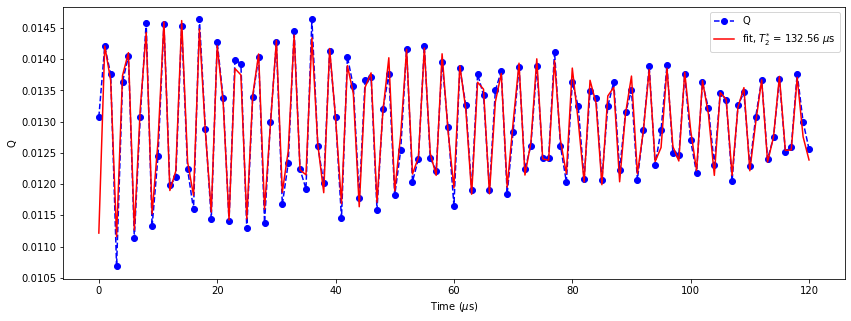

In [154]:
expt_name = 'Ramsey_phase'
filelist = [1, 5, 7]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        t = array(a['time'])
        ramsey_freq = array(a['ramsey_freq'])/1e6
        qubit_freq = array(a['qubit_freq'])/1e9
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        P = Q
        p = fitdecaysin(t[:], P[:],fitparams = None, showfit=False)
        ax.plot(t, P, 'bo--',label = 'Q')
        ax.plot(t[:], decaysin(np.append(p, 0), t[:]), 'r-', label=r'fit, $T_{2}^{*}$ = %.2f $\mu$s' % p[3])
        offset = ramsey_freq - p[1]
        nu_q_new = qubit_freq + offset/1e3
        print("Original qubit frequency choice =", qubit_freq,"GHz")
        print ("Oscillation freq = ", p[1]," MHz")
        print("Offset freq =", offset,"MHz")
        print("Suggested qubit frequency choice =", nu_q_new,"GHz")
        print("T2* =", p[3],"us")
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel('Q')
        ax.legend()

# Power Rabi

Suggested π amp =  0.35114640865853564
Suggested π amp =  0.347626541849614
Suggested π amp =  0.34839545472767824


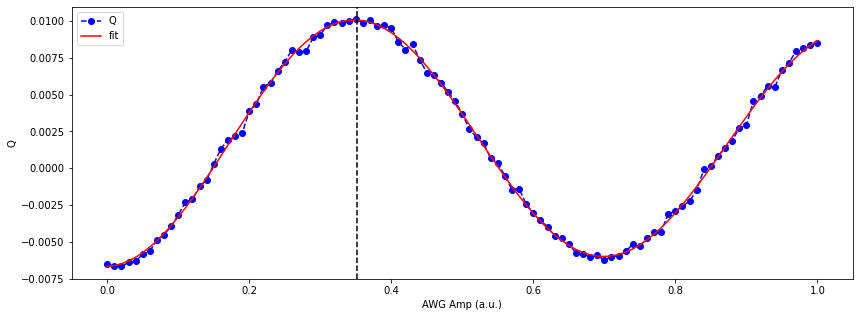

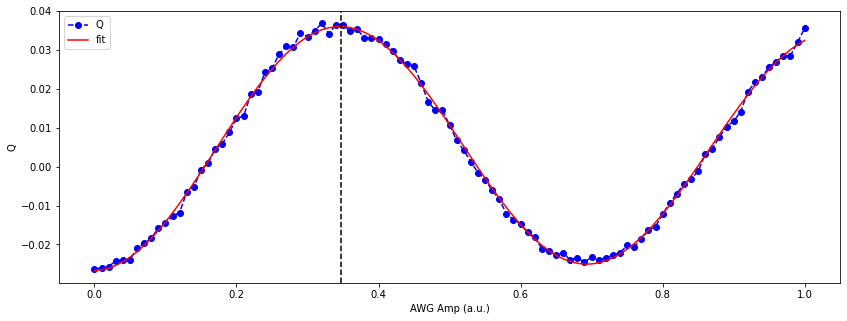

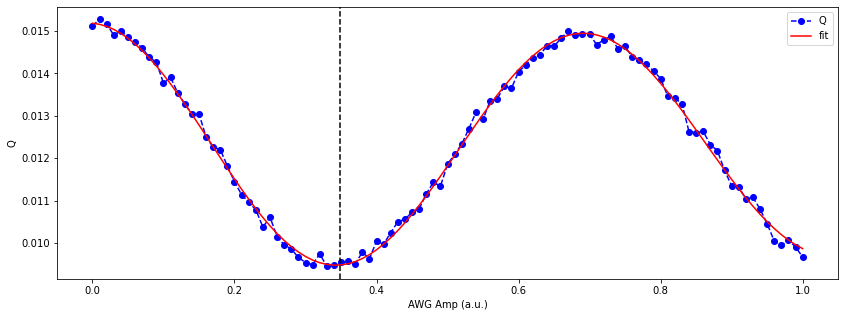

In [122]:
expt_name = 'power_rabi'
filelist = [1, 19, 20]
freq = []
t2 = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['amps'])
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        y = Q
        p = fitdecaysin(x[:], y[:],fitparams = None, showfit=False)
        ax.plot(x, y, 'bo--',label = 'Q')
        ax.plot(x[:], decaysin(np.append(p, 0), x[:]), 'r-', label=r'fit')
        print("Suggested π amp = ", 1/2/p[1])
        ax.axvline(1/2/p[1], color='k', linestyle='--')
        ax.set_xlabel('AWG Amp (a.u.)')
        ax.set_ylabel('Q')
        ax.legend()

# T1

T1: 92.084 μs
T1: 94.961 μs
T1: 102.387 μs


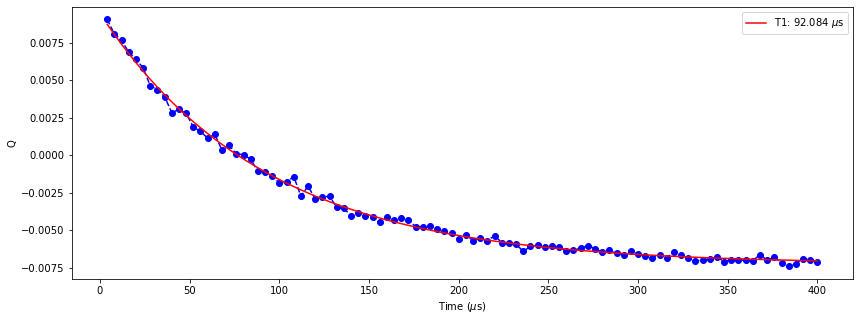

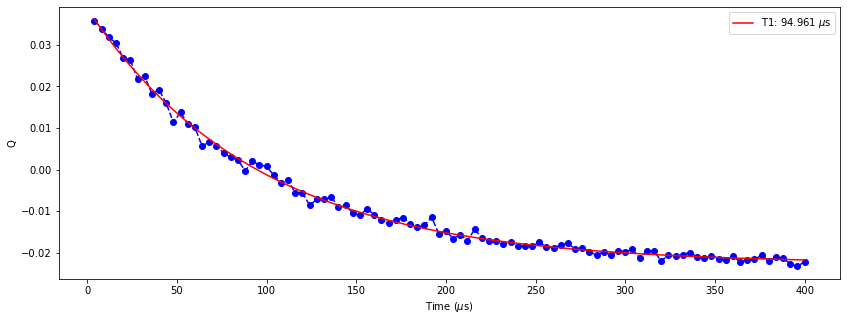

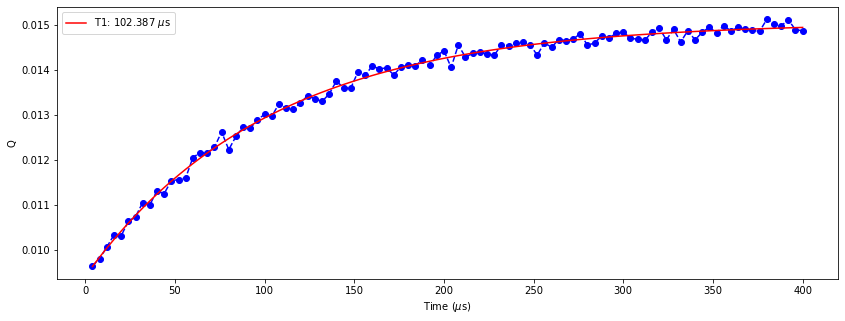

In [120]:
expt_name = 't1'
filelist = [0, 9, 13]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['time'])/1e3
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        y = Q
        p = fitexp(x, y, showfit=False)
        print("T1: %.3f μs"%(p[3]))
        ax.plot(x, y, 'bo--')
        ax.plot(x[:], expfunc(p, x[:]), 'r-', label='T1: %.3f $\mu$s'%(p[3]))
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel('Q')
        ax.legend()


# Histogram 

## Square

C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Optimal fidelity after rotation = 0.818
Optimal fidelity after rotation = 0.811
Optimal fidelity after rotation = 0.904


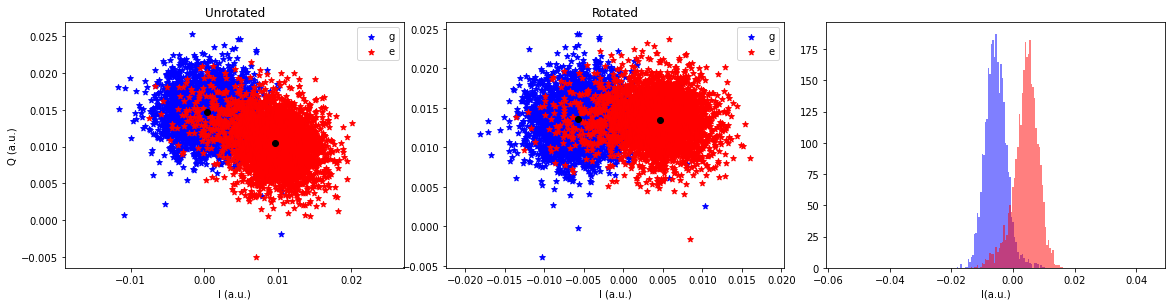

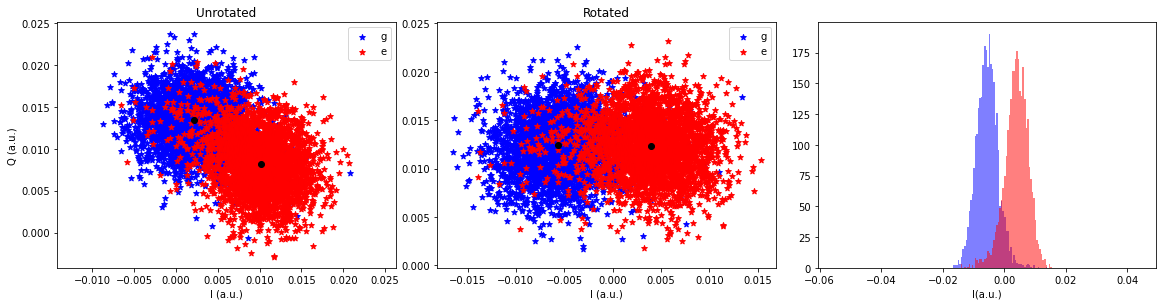

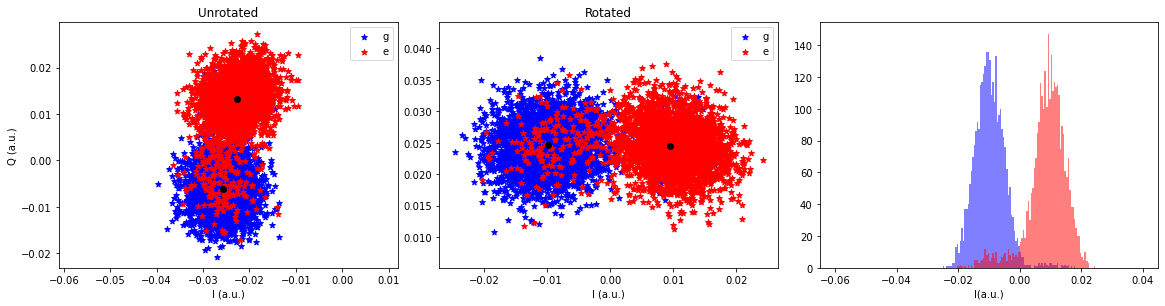

In [123]:
expt_name = 'histogram'
filelist = [35, 100, 107]

for ii, i in enumerate(filelist[::-1]):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    fid, angle = hist(filename, data=None,  plot=True, ran=0.05)
    print('Optimal fidelity after rotation = %.3f'%fid)

### Freq and amp sweep

In [8]:
expt_name = 'histogram_freq_amp_sweep'
filelist = [9]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        attens = array(a['amp'])
        freqs = array(a['freq'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 3000
    for ii in range(len(attens)):
        """Select all the rows corresponding to the same readout power"""
        ig, qg = Ig.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qg.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        ie, qe = Ie.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qe.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        fid_freq = []
        """For the same readout power, compute the g|e fidelity corresponding to each readout frequency"""
        for jj in range(len(freqs)):
            a = ig.iloc[jj:(jj+1)*avgs]
            b = qg.iloc[jj:(jj+1)*avgs]
            c = ie.iloc[jj:(jj+1)*avgs]
            d = qe.iloc[jj:(jj+1)*avgs]
            data = [a, b, c, d]
            fid, angle = hist(filename=None, data=data, plot=False, ran=0.2)
            fid_freq.append(fid)
        fid_f_p.append(fid_freq)

(378000,)


36 0.802


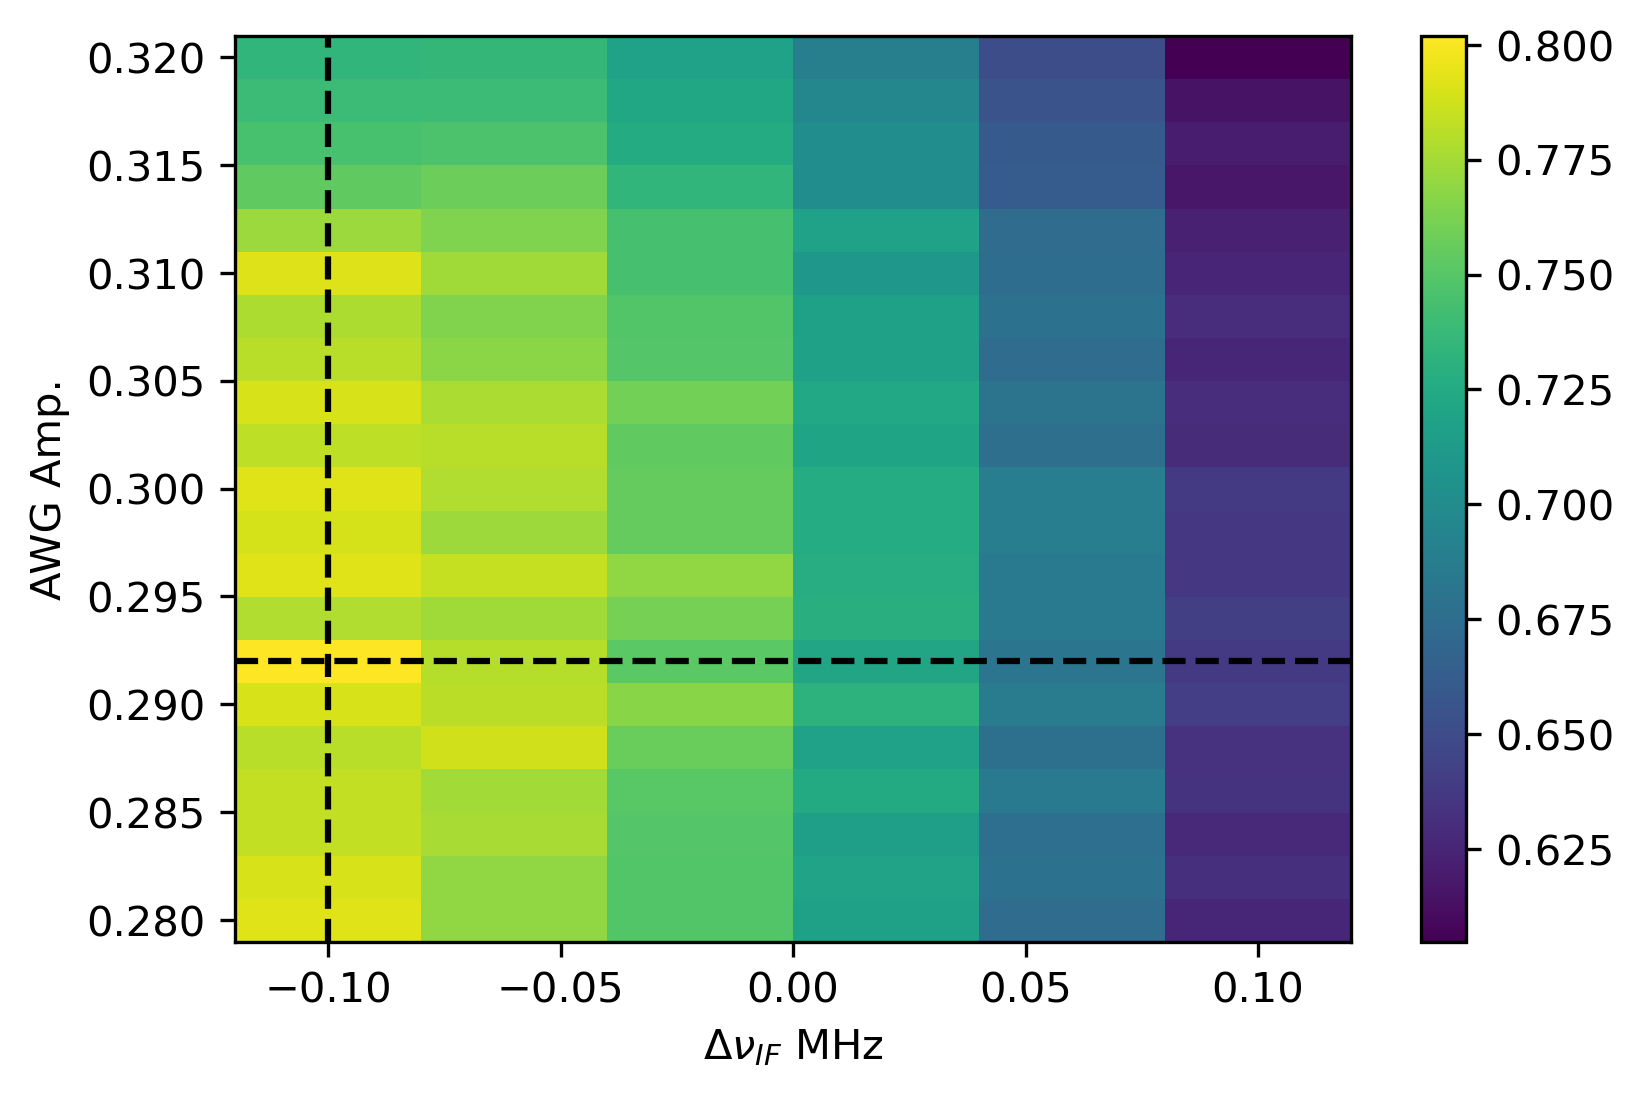

In [9]:
ind = np.argmax(fid_f_p)
fid_max = np.max(fid_f_p)
print(ind, fid_max)

plt.figure(dpi=300)
plt.pcolormesh(freqs/1e6, attens, fid_f_p, shading='auto')
plt.colorbar()
plt.xlabel(r'$\Delta \nu_{IF}$ MHz')
plt.ylabel('AWG Amp.')
plt.axvline(x = freqs[ind%len(freqs)]/1e6, linestyle='--', color='k')
plt.axhline(y = attens[ind//len(freqs)], linestyle='--', color='k')
plt.show()

In [ ]:
freqs[ind%len(freqs)]/1e6, attens[ind//len(freqs)]

### Amp sweep 

(303000,)


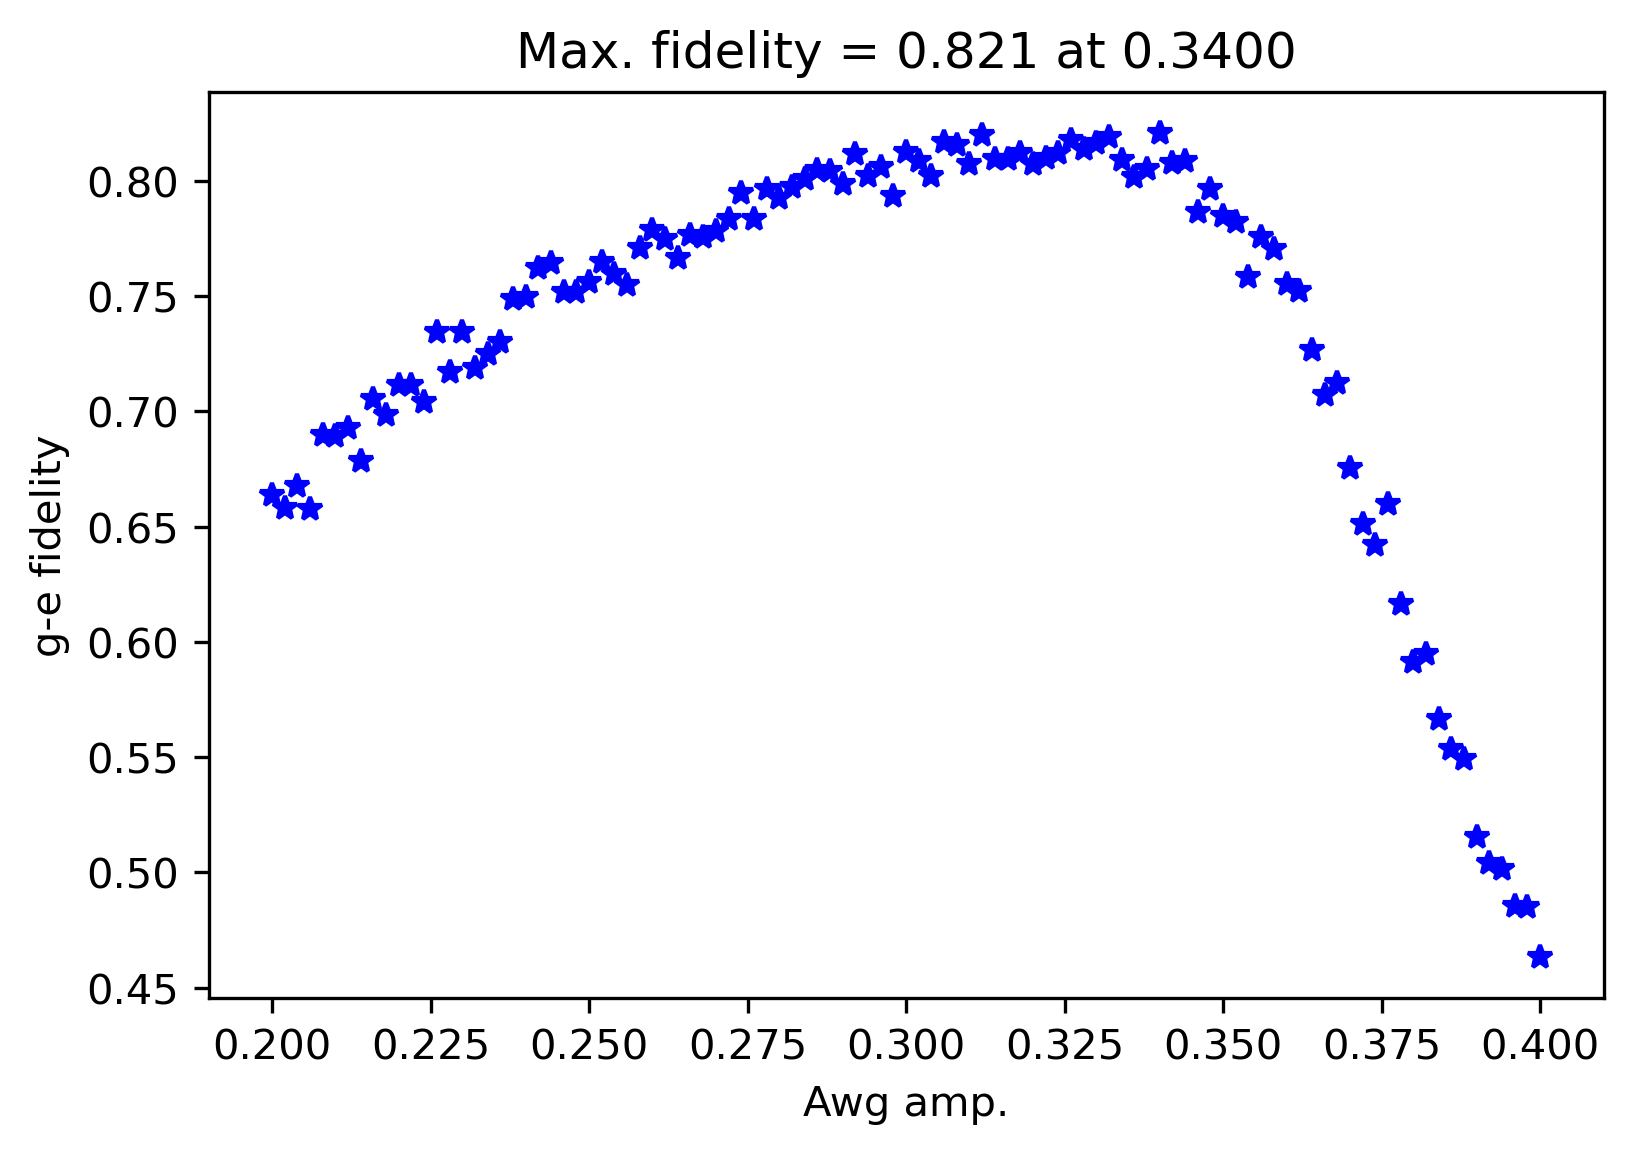

In [125]:
expt_name = 'histogram_amp_sweep'
filelist = [5]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        amp = array(a['amp'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 3000
    for ii in range(len(amp)):
        """Select all the rows corresponding to the same readout power"""
        a, b = Ig.iloc[ii*avgs: (ii+1)*avgs], Qg.iloc[ii*avgs: (ii+1)*avgs]
        c, d = Ie.iloc[ii*avgs: (ii+1)*avgs], Qe.iloc[ii*avgs: (ii+1)*avgs]
        data = [a, b, c, d]
        fid, angle = hist(filename=None, data=data, plot=False, ran=0.2)
        fid_f_p.append(fid)

plt.figure(dpi=300)
plt.plot(amp, fid_f_p, 'b*')
plt.title('Max. fidelity = %.3f at %.4f'%(max(fid_f_p), amp[np.argmax(fid_f_p)]))
plt.xlabel('Awg amp.')
plt.ylabel('g-e fidelity')
plt.show()

### Freq sweep

(63000,)


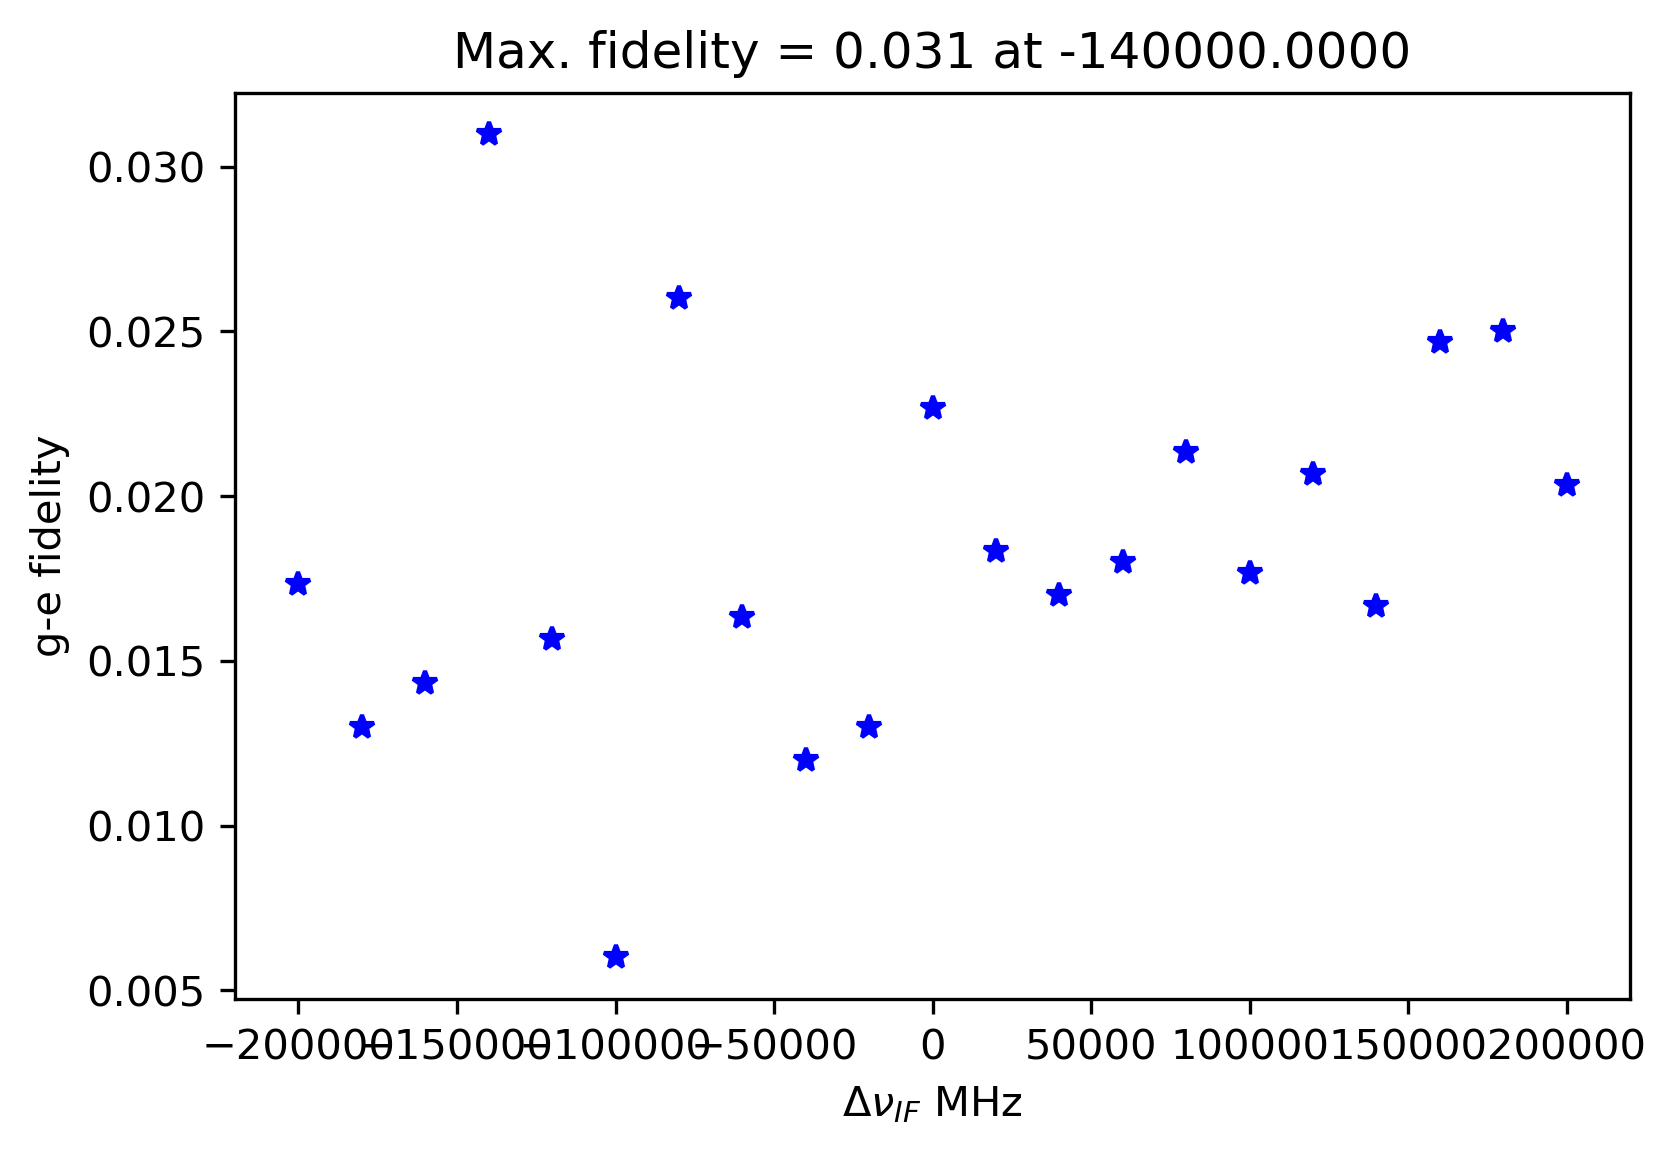

0.031


In [112]:
expt_name = 'histogram_freq_sweep'
filelist = [1]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        freq = array(a['freq'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 3000
    for ii in range(len(freq)):
        """Select all the rows corresponding to the same readout power"""
        a, b = Ig.iloc[ii*avgs: (ii+1)*avgs], Qg.iloc[ii*avgs: (ii+1)*avgs]
        c, d = Ie.iloc[ii*avgs: (ii+1)*avgs], Qe.iloc[ii*avgs: (ii+1)*avgs]
        data = [a, b, c, d]
        fid, angle = hist(filename=None, data=data, plot=False, ran=0.2)
        fid_f_p.append(fid)

plt.figure(dpi=300)
plt.plot(freq, fid_f_p, 'b*')
plt.title('Max. fidelity = %.3f at %.4f'%(max(fid_f_p), freq[np.argmax(fid_f_p)]))
plt.xlabel(r'$\Delta \nu_{IF}$ MHz')
plt.ylabel('g-e fidelity')
plt.show()
print(max(fid_f_p))

(-0.1, 0.29200000000000004)

## JPA

C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Optimal fidelity after rotation = 0.863
Optimal fidelity after rotation = 0.335
Optimal fidelity after rotation = 0.855
Optimal fidelity after rotation = 0.920


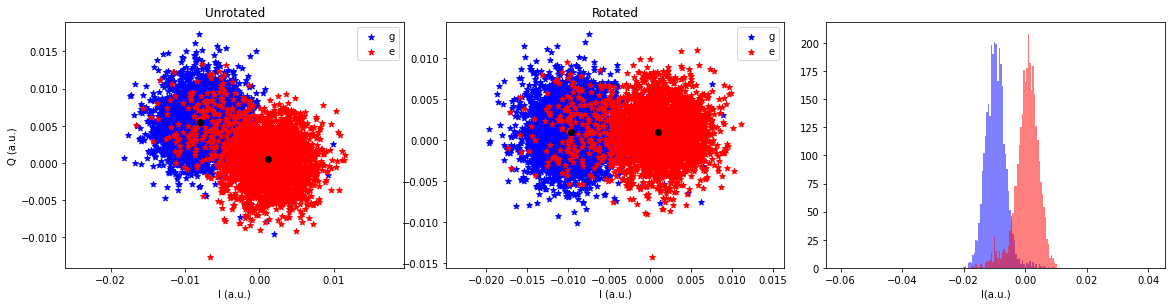

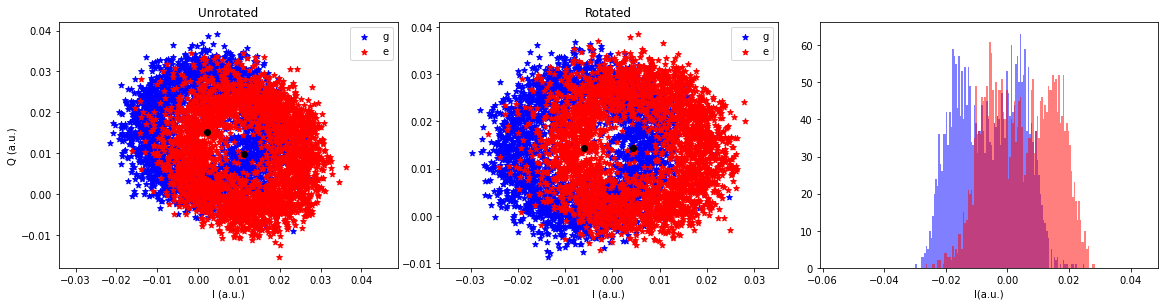

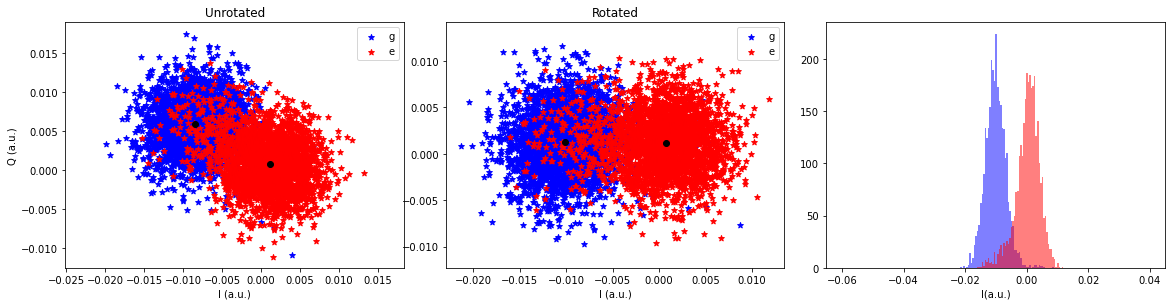

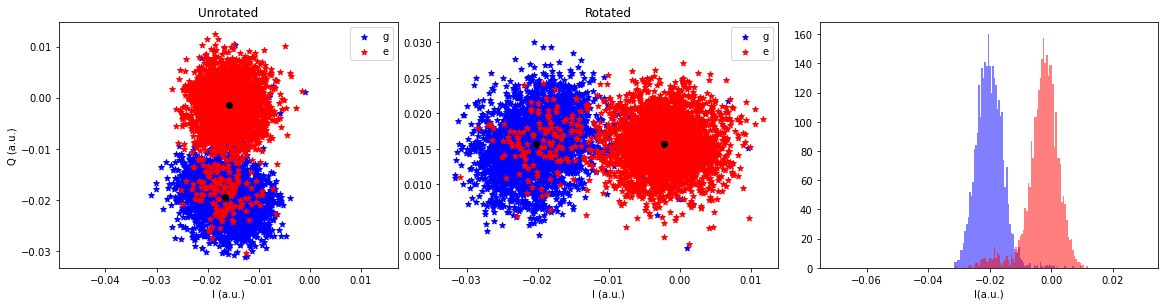

In [114]:
expt_name = 'histogram_jpa'
filelist = [4, 80, 81, 85]
#43 - 2μs 
#24 - 1μs and 0.5*rramp
for ii, i in enumerate(filelist[::-1]):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        fid, angle = hist(filename, data=None, plot=True, ran=0.05)

    print('Optimal fidelity after rotation = %.3f'%fid)

### JPA freq and amp sweep, 4μs

In [3]:
expt_name = 'histogram_jpa_freq_amp_sweep'
filelist = [3]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        attens = array(a['amp'])
        freqs = array(a['freq'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 3000
    for ii in range(len(attens)):
        """Select all the rows corresponding to the same readout power"""
        ig, qg = Ig.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qg.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        ie, qe = Ie.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qe.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        fid_freq = []
        """For the same readout power, compute the g|e fidelity corresponding to each readout frequency"""
        for jj in range(len(freqs)):
            a = ig.iloc[jj:(jj+1)*avgs]
            b = qg.iloc[jj:(jj+1)*avgs]
            c = ie.iloc[jj:(jj+1)*avgs]
            d = qe.iloc[jj:(jj+1)*avgs]
            data = [a, b, c, d]
            fid, angle = hist(filename=None, data=data, plot=False)
            fid_freq.append(fid)
        fid_f_p.append(fid_freq)

(363000,)


0 0.8126666666666666


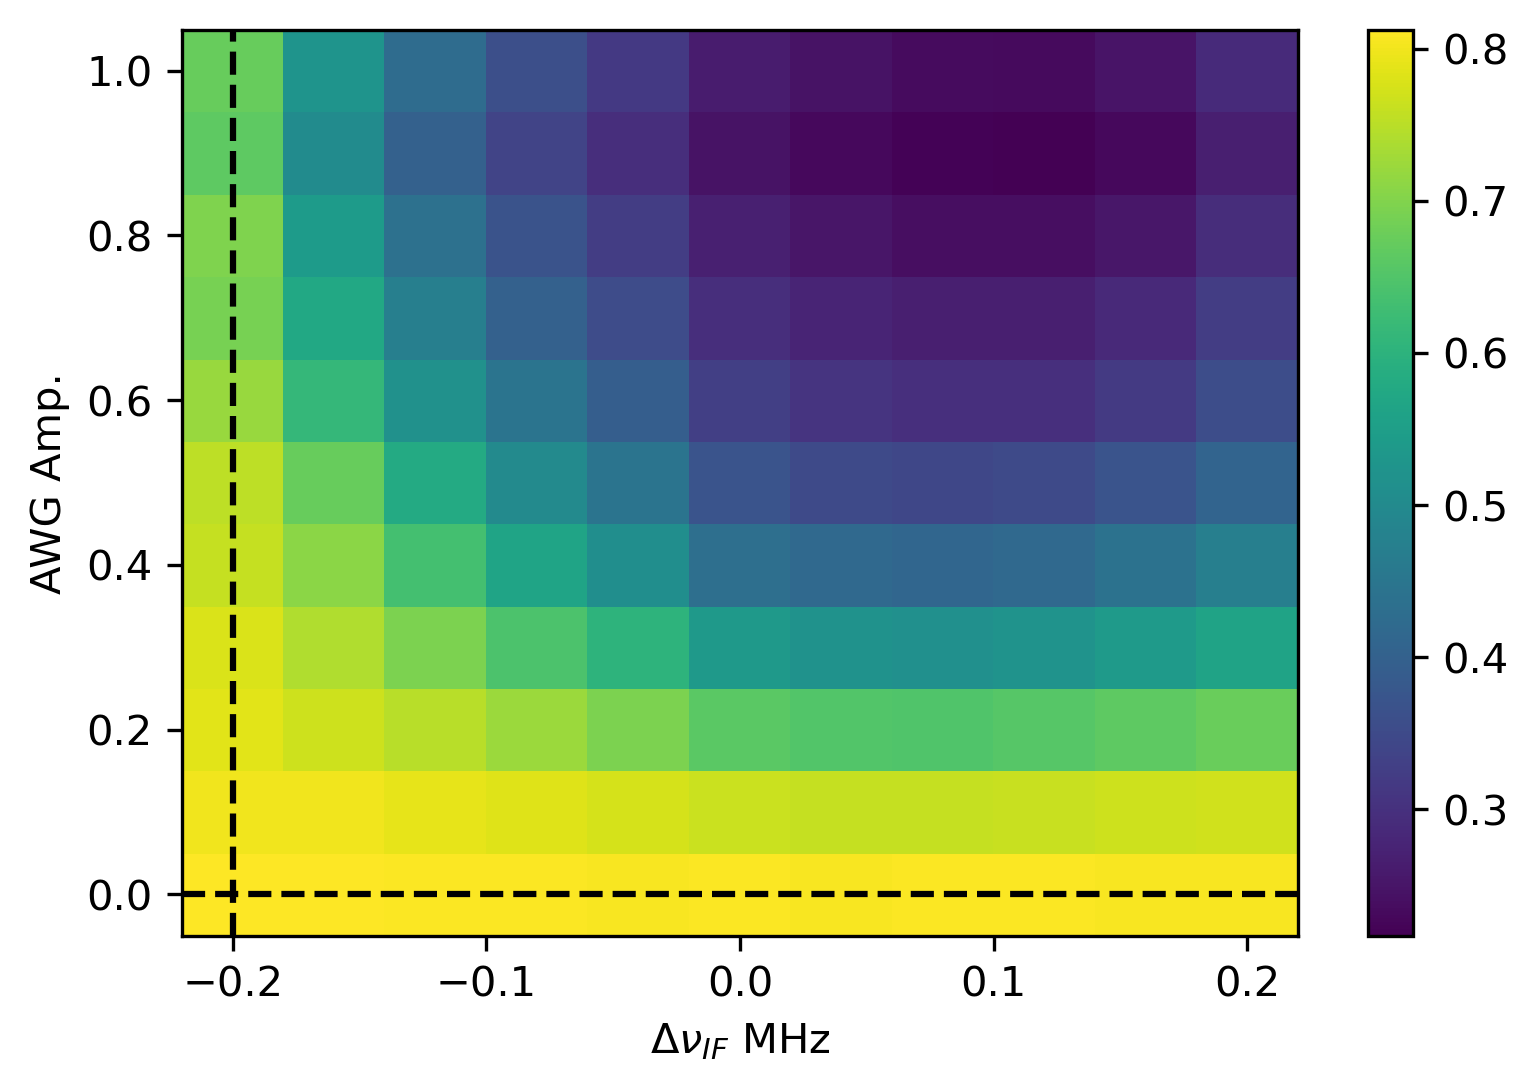

In [5]:
ind = np.argmax(fid_f_p)
fid_max = np.max(fid_f_p)
print(ind, fid_max)
plt.figure(dpi=300)
plt.pcolormesh(freqs/1e6, attens, fid_f_p, shading='auto')
plt.colorbar()
plt.xlabel(r'$\Delta \nu_{IF}$ MHz')
plt.ylabel('AWG Amp.')
plt.axvline(x = freqs[ind%len(freqs)]/1e6, linestyle='--', color='k')
plt.axhline(y = attens[ind//len(freqs)], linestyle='--', color='k')
plt.show()


### Amp sweep

(93000,)


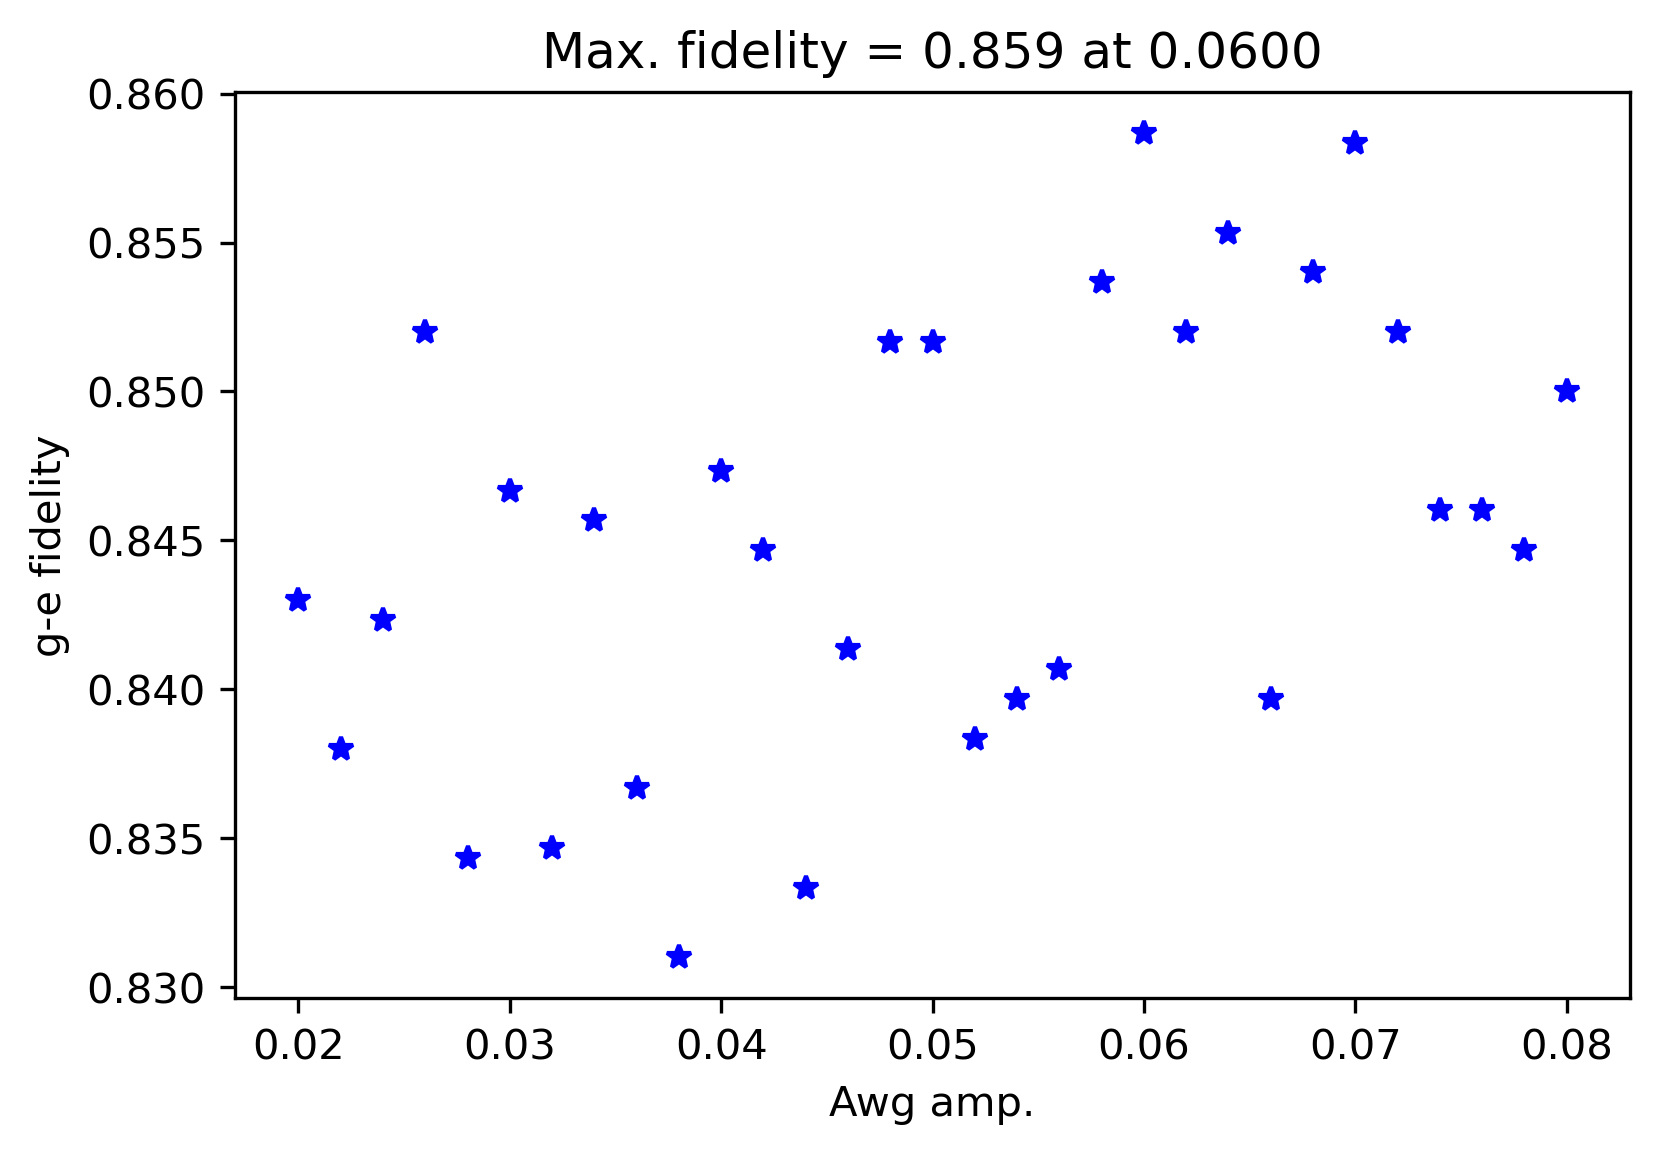

0.8586666666666667


In [115]:
expt_name = 'histogram_jpa_amp_sweep'
filelist = [4]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        amp = array(a['amp'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 3000
    for ii in range(len(amp)):
        """Select all the rows corresponding to the same readout power"""
        a, b = Ig.iloc[ii*avgs: (ii+1)*avgs], Qg.iloc[ii*avgs: (ii+1)*avgs]
        c, d = Ie.iloc[ii*avgs: (ii+1)*avgs], Qe.iloc[ii*avgs: (ii+1)*avgs]
        data = [a, b, c, d]
        fid, angle = hist(filename=None, data=data, plot=False, ran=0.2)
        fid_f_p.append(fid)

    plt.figure(dpi=300)
    plt.plot(amp, fid_f_p, 'b*')
    plt.title('Max. fidelity = %.3f at %.4f'%(max(fid_f_p), amp[np.argmax(fid_f_p)]))
    plt.xlabel('Awg amp.')
    plt.ylabel('g-e fidelity')
    plt.show()
    print(max(fid_f_p))

## JPA freq and amp sweep, 3 μs

In [118]:
expt_name = 'histogram_jpa_freq_amp_sweep'
filelist = [2]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        attens = 0.035*array(a['amp'])
        freqs = array(a['freq'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 3000
    for ii in range(len(attens)):
        """Select all the rows corresponding to the same readout power"""
        ig, qg = Ig.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qg.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        ie, qe = Ie.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qe.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        fid_freq = []
        """For the same readout power, compute the g|e fidelity corresponding to each readout frequency"""
        for jj in range(len(freqs)):
            a = ig.iloc[jj:(jj+1)*avgs]
            b = qg.iloc[jj:(jj+1)*avgs]
            c = ie.iloc[jj:(jj+1)*avgs]
            d = qe.iloc[jj:(jj+1)*avgs]
            data = [a, b, c, d]
            fid, angle = hist(filename=None, data=data, plot=False, ran=1)
            fid_freq.append(fid)
        fid_f_p.append(fid_freq)

(123000,)


ValueError: supplied range of [nan, nan] is not finite

In [116]:
np.shape(fid_f_p)

(1, 41)

In [ ]:
plt.figure(dpi=300)
plt.pcolormesh(freqs/1e6, attens, fid_f_p, shading='auto')
plt.colorbar()
plt.xlabel(r'$\Delta \nu_{IF}$ MHz')
plt.ylabel('AWG Amp.')
plt.axvline(x = freqs[ind%len(freqs)]/1e6, linestyle='--', color='k')
plt.axhline(y = attens[ind//len(freqs)], linestyle='--', color='k')
plt.show()
ind = np.argmax(fid_f_p)
fid_max = np.max(fid_f_p)
print(ind, fid_max)

## CLEAR 

-0.006759271696458749 0.008440728303541256
Optimal fidelity after rotation = 0.891


C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:180: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


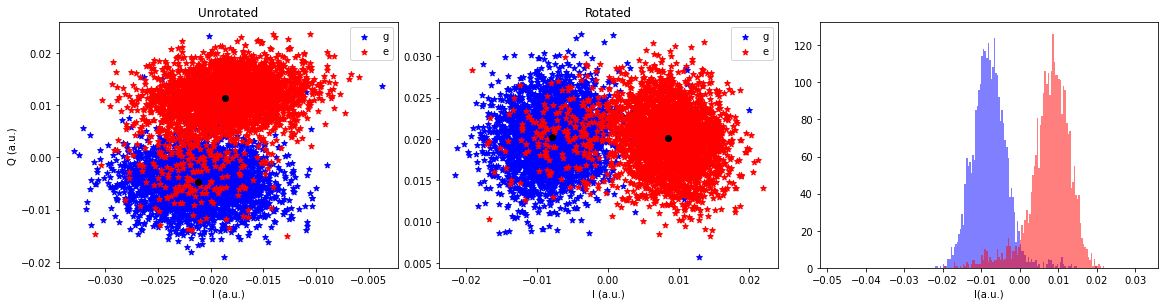

In [490]:
expt_name = 'histogram_clear'
filelist = [4]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    fid, angle = hist(filename)

    print('Optimal fidelity after rotation = %.3f'%fid)

# Readout population

## Optimal shape

C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


0.8953333333333333 -1.5025833989090813


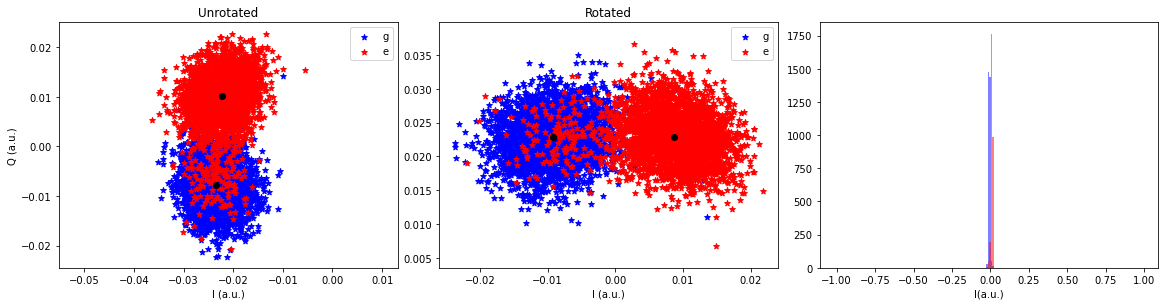

In [126]:
expt_name = 'ramsey_clear'
filelist = [0]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I_opt = pd.DataFrame(a['I'])
        Q_opt = pd.DataFrame(a['Q'])
        wait_times = array(a['wait_time'])/1e9
        ramsey_times = array(a['ramsey_times'])/1e9
        
hist_filename = "..\\data\\" + str(8).zfill(5) + "_histogram.h5"
i_rot_opt, q_rot_opt = rot_data(I_opt, Q_opt, hist_filename) 

## Square pulse

C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


0.8963333333333333 -1.4162114403813486


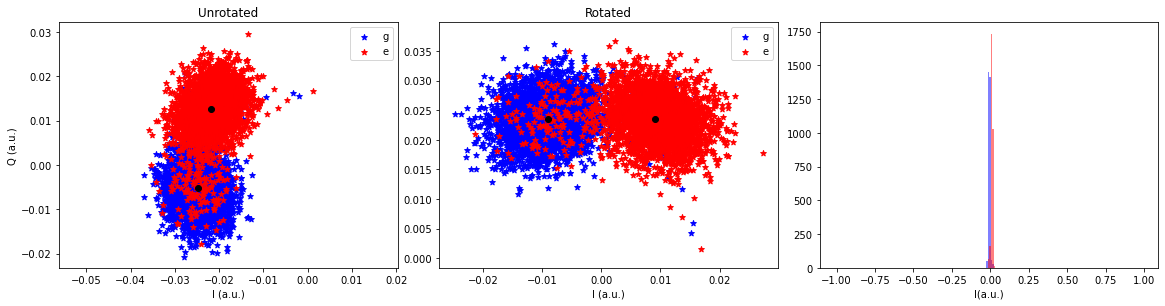

In [127]:
expt_name = 'ramsey_square'
filelist = [0]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I_sq = pd.DataFrame(a['I'])
        Q_sq = pd.DataFrame(a['Q'])
        wait_times = array(a['wait_time'])/1e9
        ramsey_times = array(a['ramsey_times'])/1e9
        
hist_filename = "..\\data\\" + str(9).zfill(5) + "_histogram.h5"
i_rot_sq, q_rot_sq = rot_data(I_sq, Q_sq, hist_filename) 

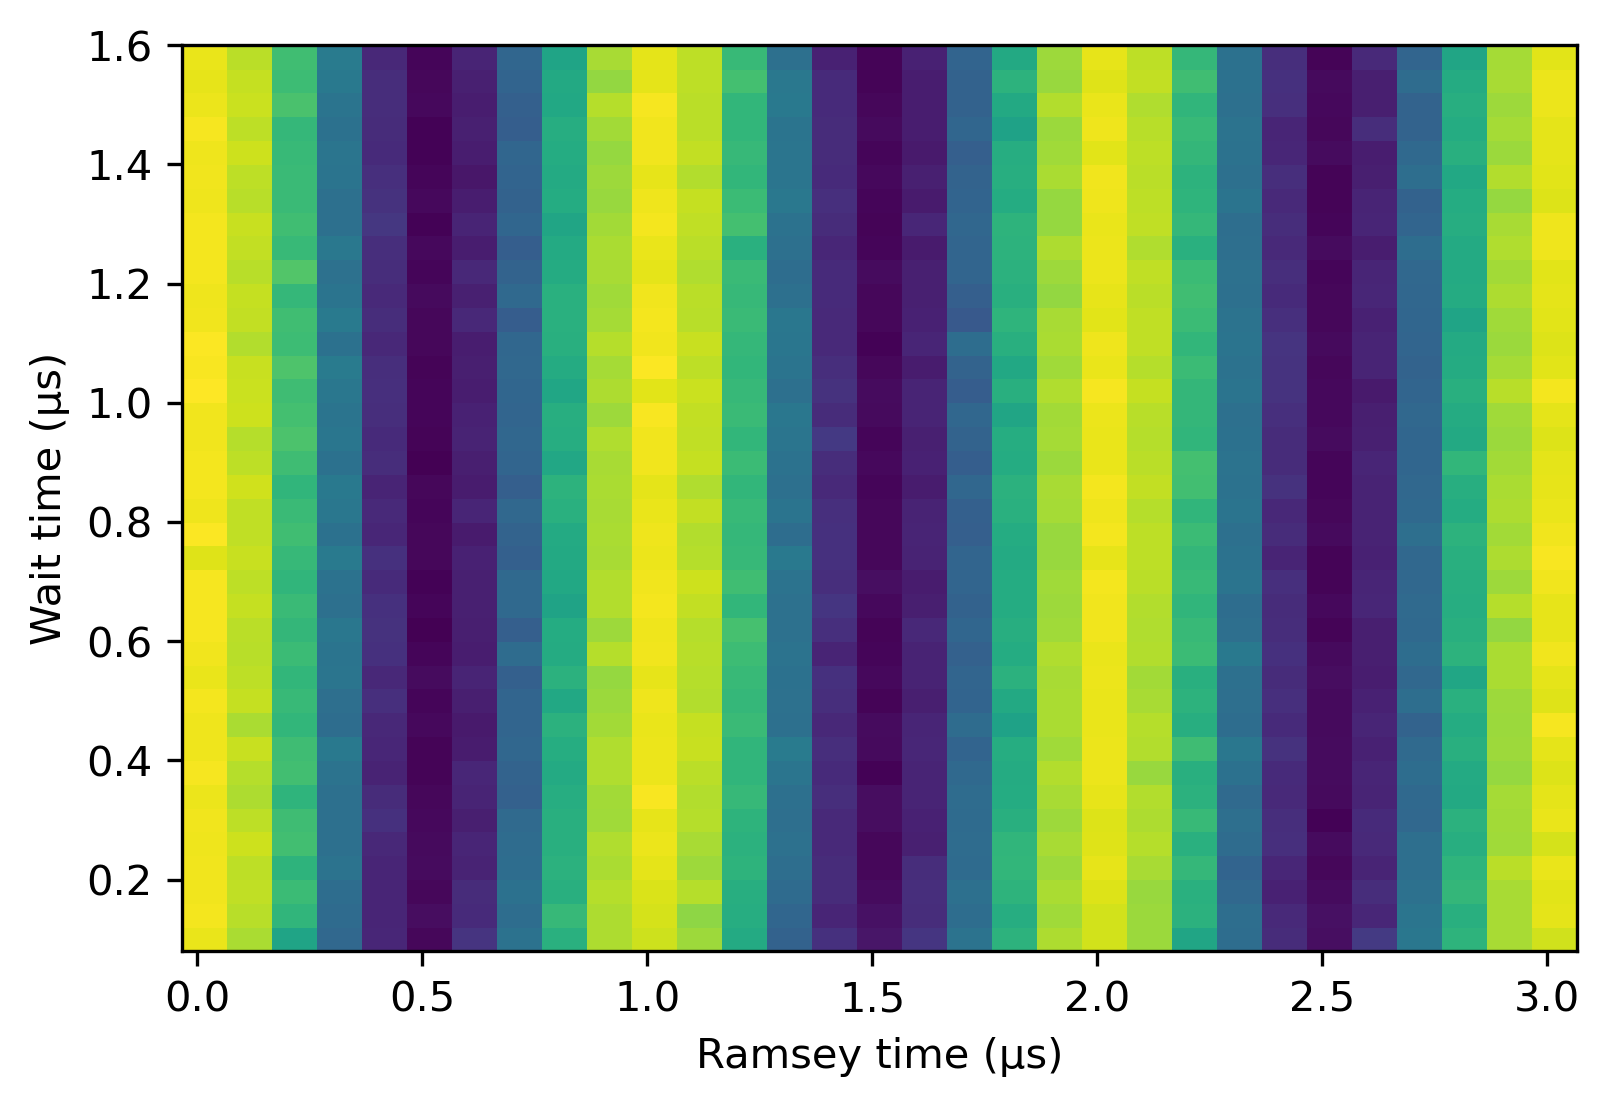

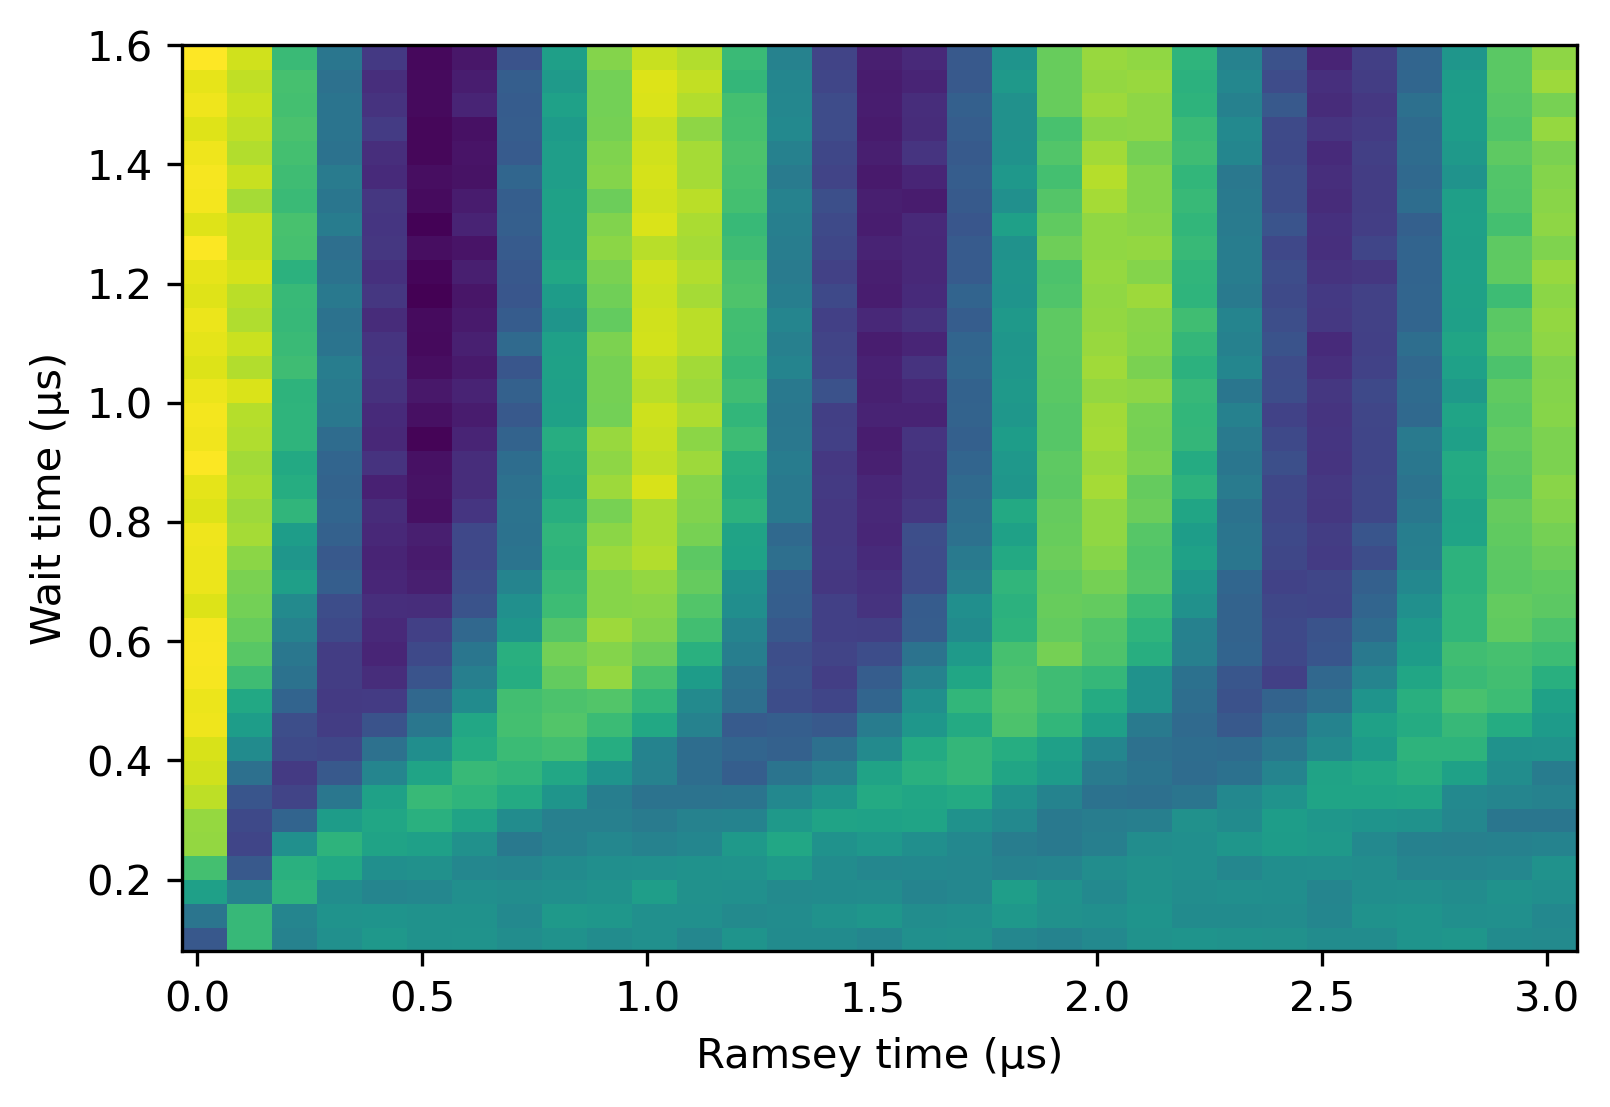

In [128]:
plt.figure(dpi=300)
plt.pcolormesh(ramsey_times*1e6, wait_times*1e6, i_rot_opt, shading='auto')
plt.xlabel('Ramsey time (μs)')
plt.ylabel('Wait time (μs)')
plt.savefig('S:\Morgan\qm_opx\morgan\plots\opt_pulse_2d_buffer.png')
plt.show()

plt.figure(dpi=300)
plt.pcolormesh(ramsey_times*1e6, wait_times*1e6, i_rot_sq, shading='auto')
plt.xlabel('Ramsey time (μs)')
plt.ylabel('Wait time (μs)')
# plt.savefig('S:\Morgan\qm_opx\morgan\plots\square_pulse_2d_buffer.png')
plt.show()

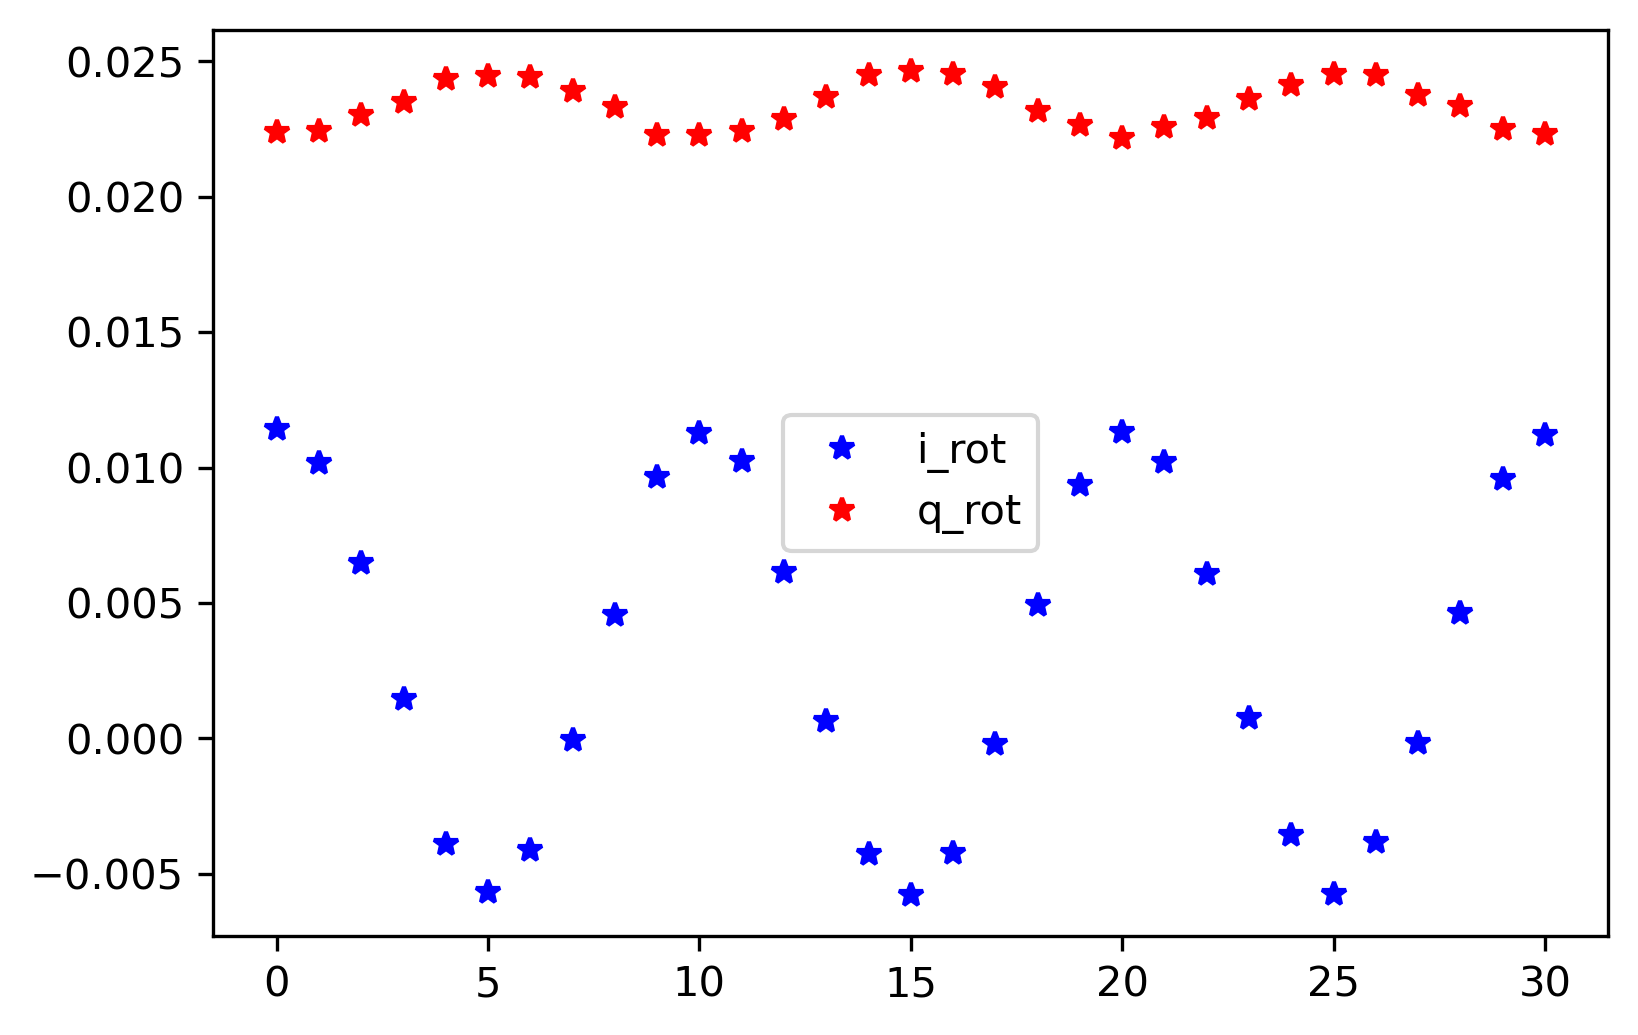

In [129]:
plt.figure(dpi=300)
plt.plot(i_rot_opt.iloc[-1], 'b*', label='i_rot')
plt.plot(q_rot_opt.iloc[-1], 'r*', label='q_rot')
plt.legend()
plt.show()

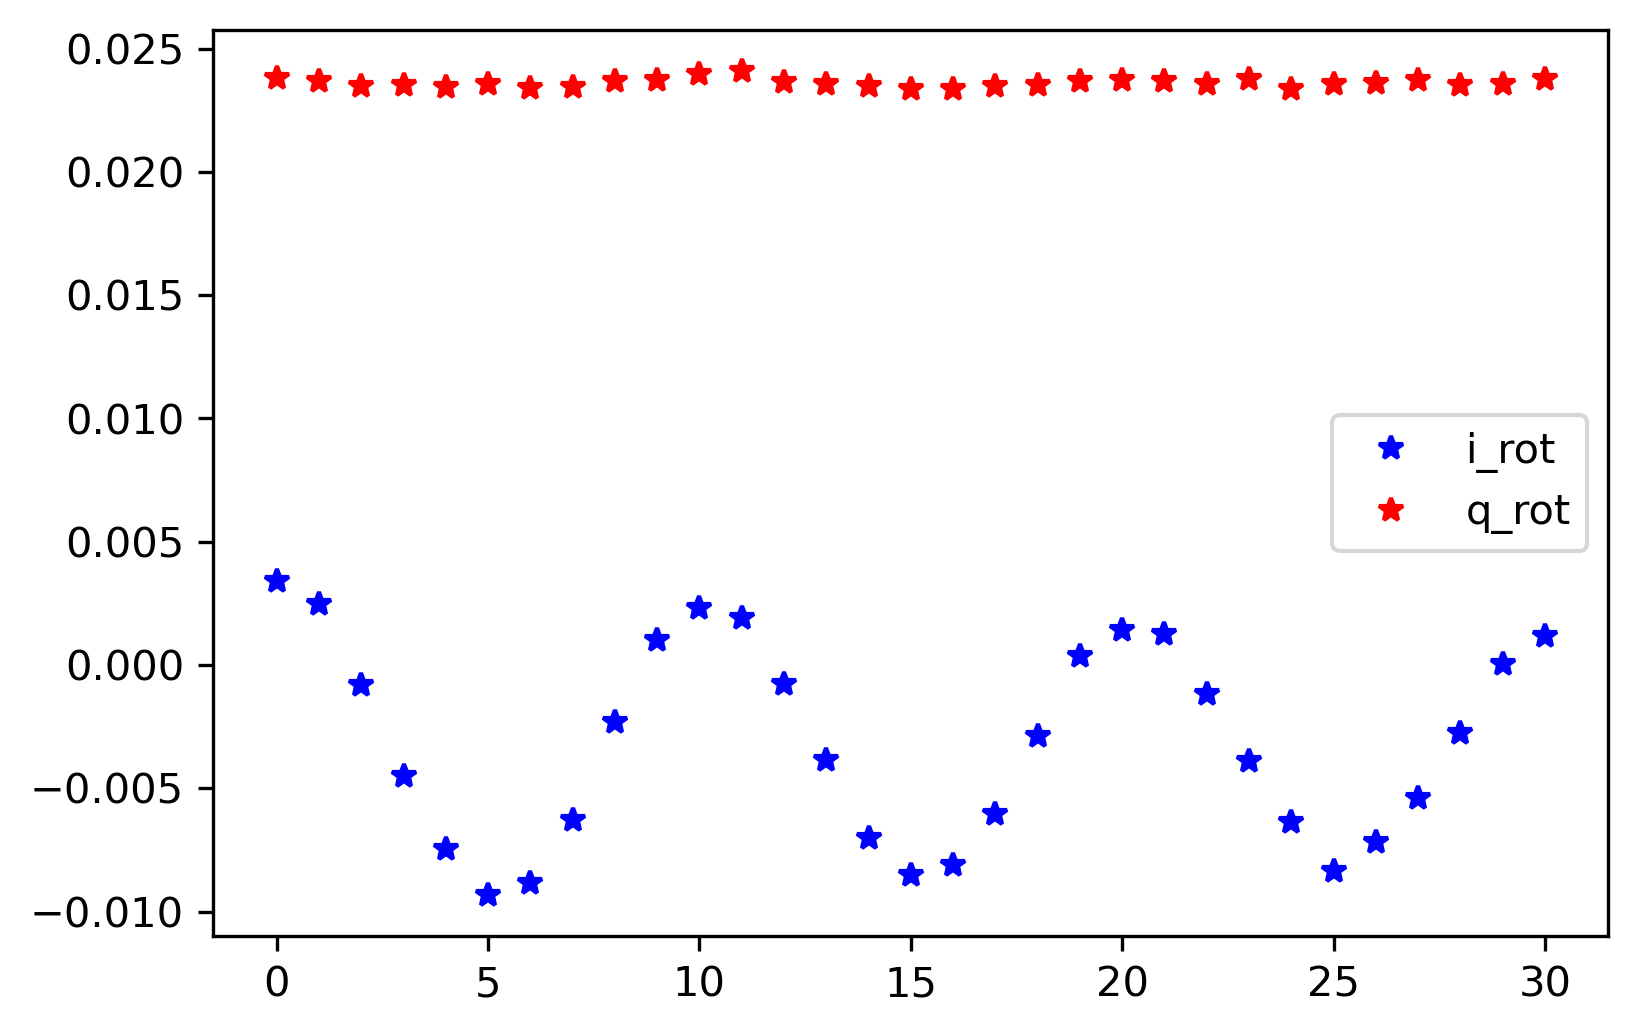

In [130]:
plt.figure(dpi=300)
plt.plot(i_rot_sq.iloc[-1], 'b*', label='i_rot')
plt.plot(q_rot_sq.iloc[-1], 'r*', label='q_rot')
plt.legend()
plt.show()

121.2025470379161


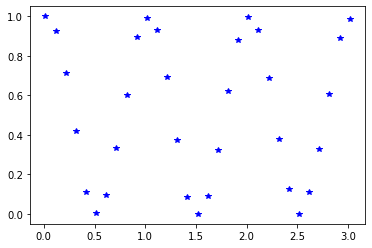

0.001930362852654799


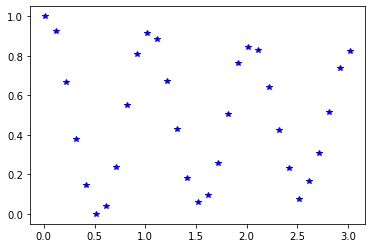

In [131]:
g = min(i_rot_opt.iloc[-1])
e = max(i_rot_opt.iloc[-1])
# g = -0.00952391
# e = 0.00883598

i_cal_opt = abs((i_rot_opt - g))/abs((-g + e))
plt.figure()
plt.plot(ramsey_times*1e6, i_cal_opt.iloc[-1], 'b*')
p = fitdecaysin(ramsey_times*1e6, i_cal_opt.iloc[-1])
print(p[3])
plt.show()


g = min(i_rot_sq.iloc[-1])
e = max(i_rot_sq.iloc[-1])

# g = -0.00936313
# e = 0.00924562
plt.figure()
i_cal_sq = (i_rot_sq - g)/(-g + e)
plt.plot(ramsey_times*1e6, i_cal_sq.iloc[-1], 'b*')
p = fitdecaysin(ramsey_times*1e6, i_cal_sq.iloc[-1])
print(p[3])
plt.show()

0.001930362852654799


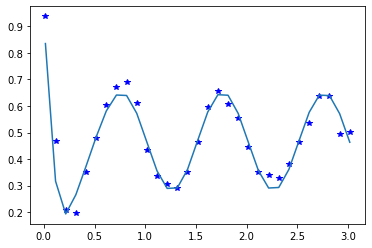

[ 2.23901895 10.60935969  0.93282584]


In [132]:
x_data = ramsey_times
y_data = i_cal_sq.iloc[8]

plt.figure()
plt.plot(x_data*1e6, y_data, 'b*')
popt, pcov = scipy.optimize.curve_fit(ramsfit, x_data[2:], y_data[2:])

plt.plot(x_data*1e6, ramsfit(x_data, popt[0], popt[1], popt[2]))
print(p[3])
plt.show()
print(popt)

C:\Users\slab\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


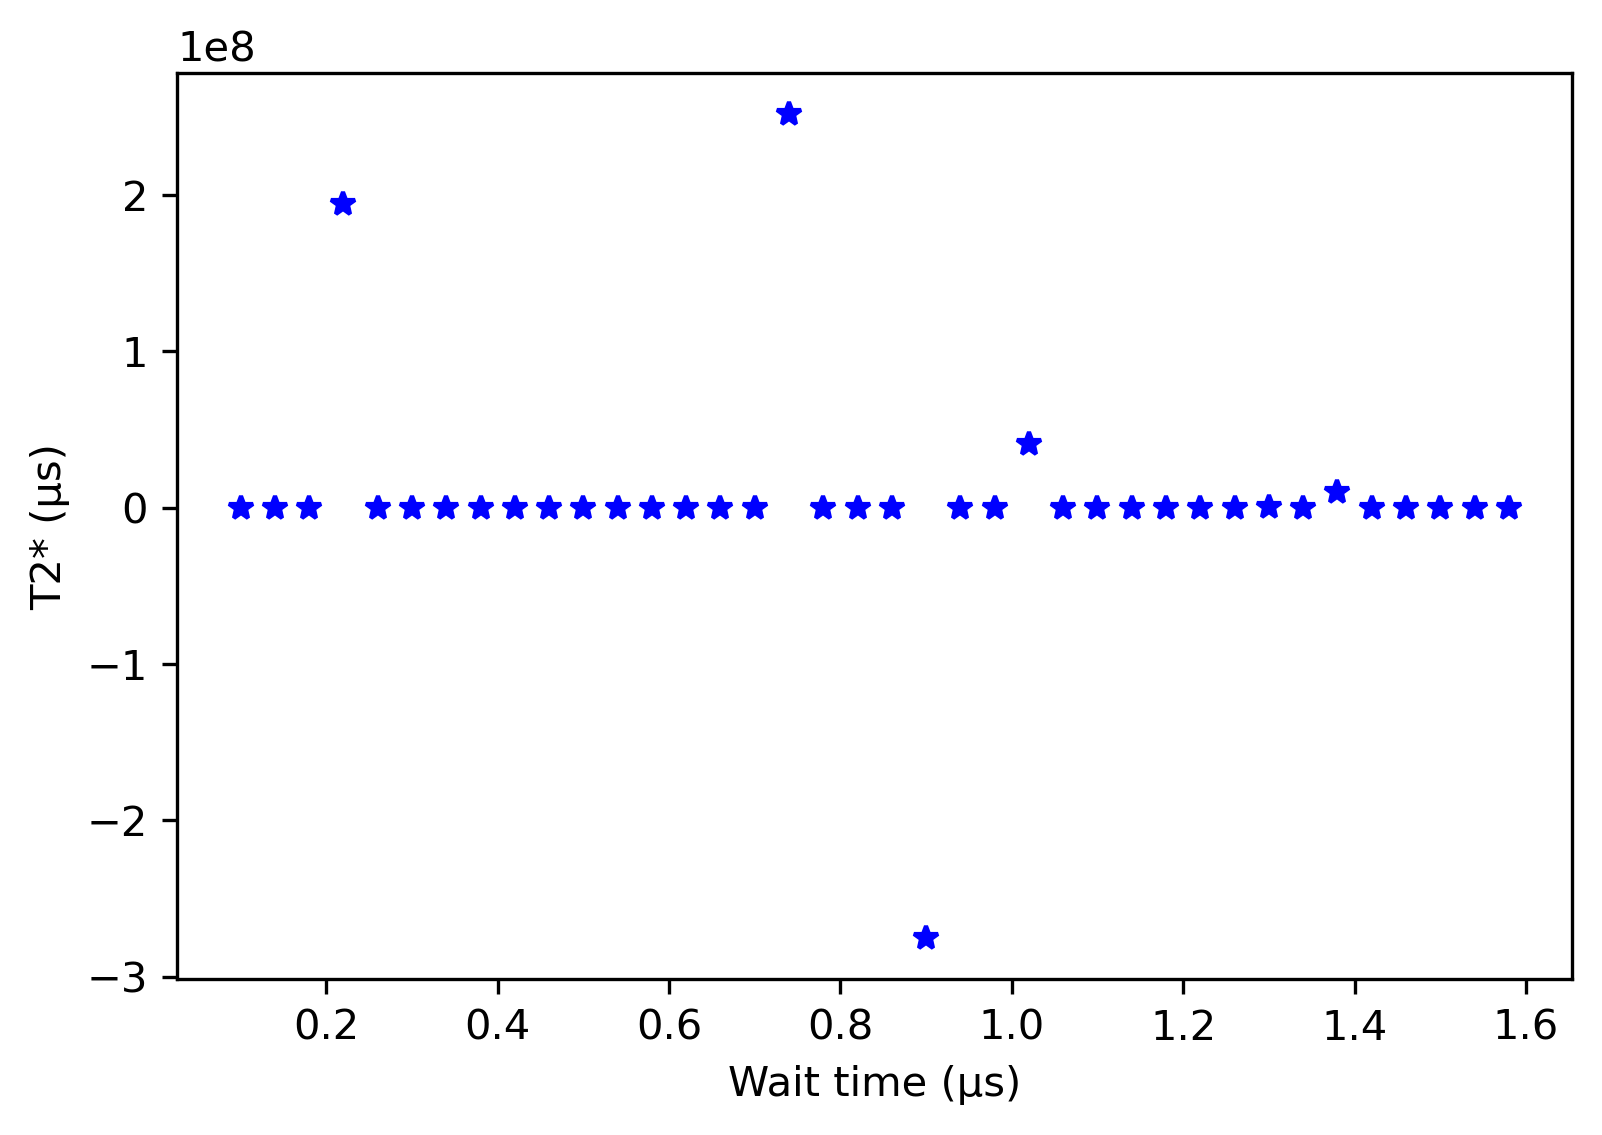

In [133]:
t2_wait = []
for i in range(len(wait_times)):
    x = np.array(ramsey_times*1e6)
    y = np.array(i_cal_opt.iloc[i])
    p = fitdecaysin(x, y, showfit=False)
    if p[3] > 200:
        p = fitdecaysin(x[2:-3], y[2:-3], showfit=False)

    t2_wait.append(p[3])
plt.figure(dpi=300)
plt.plot(wait_times*1e6, t2_wait, 'b*')
plt.ylabel('T2* (μs)')
plt.xlabel('Wait time (μs)')
plt.show()

## Comparison

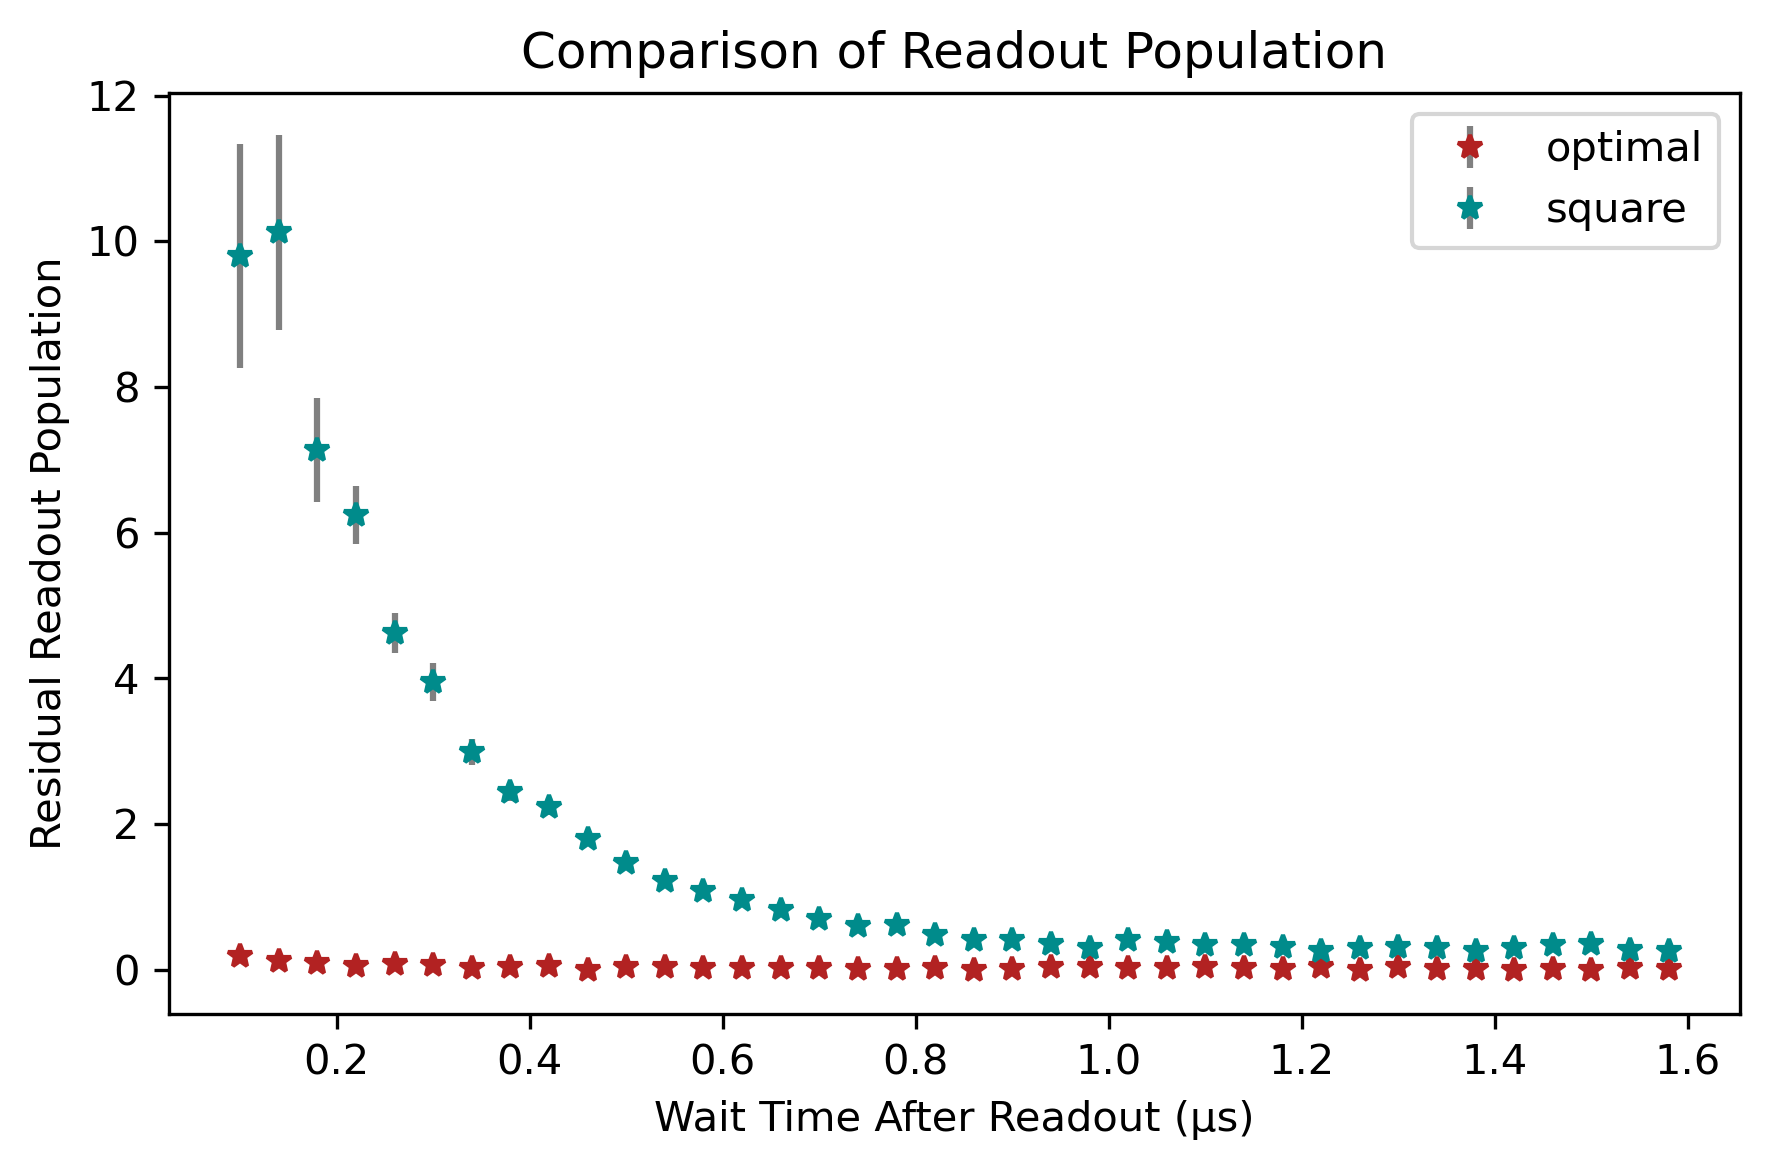

In [134]:
read_popt_opt = []
read_popt_error_opt = []
for j in range(len(wait_times)):
    y_data = i_cal_opt.iloc[j]
    x_data = ramsey_times
    popt, pcov = scipy.optimize.curve_fit(ramsfit, x_data, y_data)
    read_popt_opt.append(popt[0])
    read_popt_error_opt.append(np.sqrt(np.diag(pcov)[0]))
    
read_popt_square = []
read_popt_error_square = []
for j in range(len(wait_times)):
    y_data = i_cal_sq.iloc[j]
    x_data = ramsey_times
    popt, pcov = scipy.optimize.curve_fit(ramsfit, x_data[2:], y_data[2:])
    read_popt_square.append(popt[0])
    read_popt_error_square.append(np.sqrt(np.diag(pcov)[0]))


fig, ax1  = plt.subplots(dpi=300)
 
ax1.errorbar(wait_times*1e6, read_popt_opt, yerr = read_popt_error_opt, fmt='*', color='firebrick', 
             ecolor='grey', capthick=2, label='optimal')

ax1.errorbar(wait_times*1e6, read_popt_square, yerr = read_popt_error_square, fmt='*', color='darkcyan',
             ecolor='grey', capthick=2, label = 'square')
# ax2.tick_params(axis='y', labelcolor='darkcyan')

ax1.set_title('Comparison of Readout Population')
ax1.set_ylabel('Residual Readout Population')
ax1.set_xlabel('Wait Time After Readout (μs)')
# ax1.set_ylim(-.1, 1)
# ax2.set_ylim(-.1, 1)
plt.legend()
plt.tight_layout()
# plt.savefig('../plots/Readout_Popt_Comp_talk_full.pdf')
plt.show()

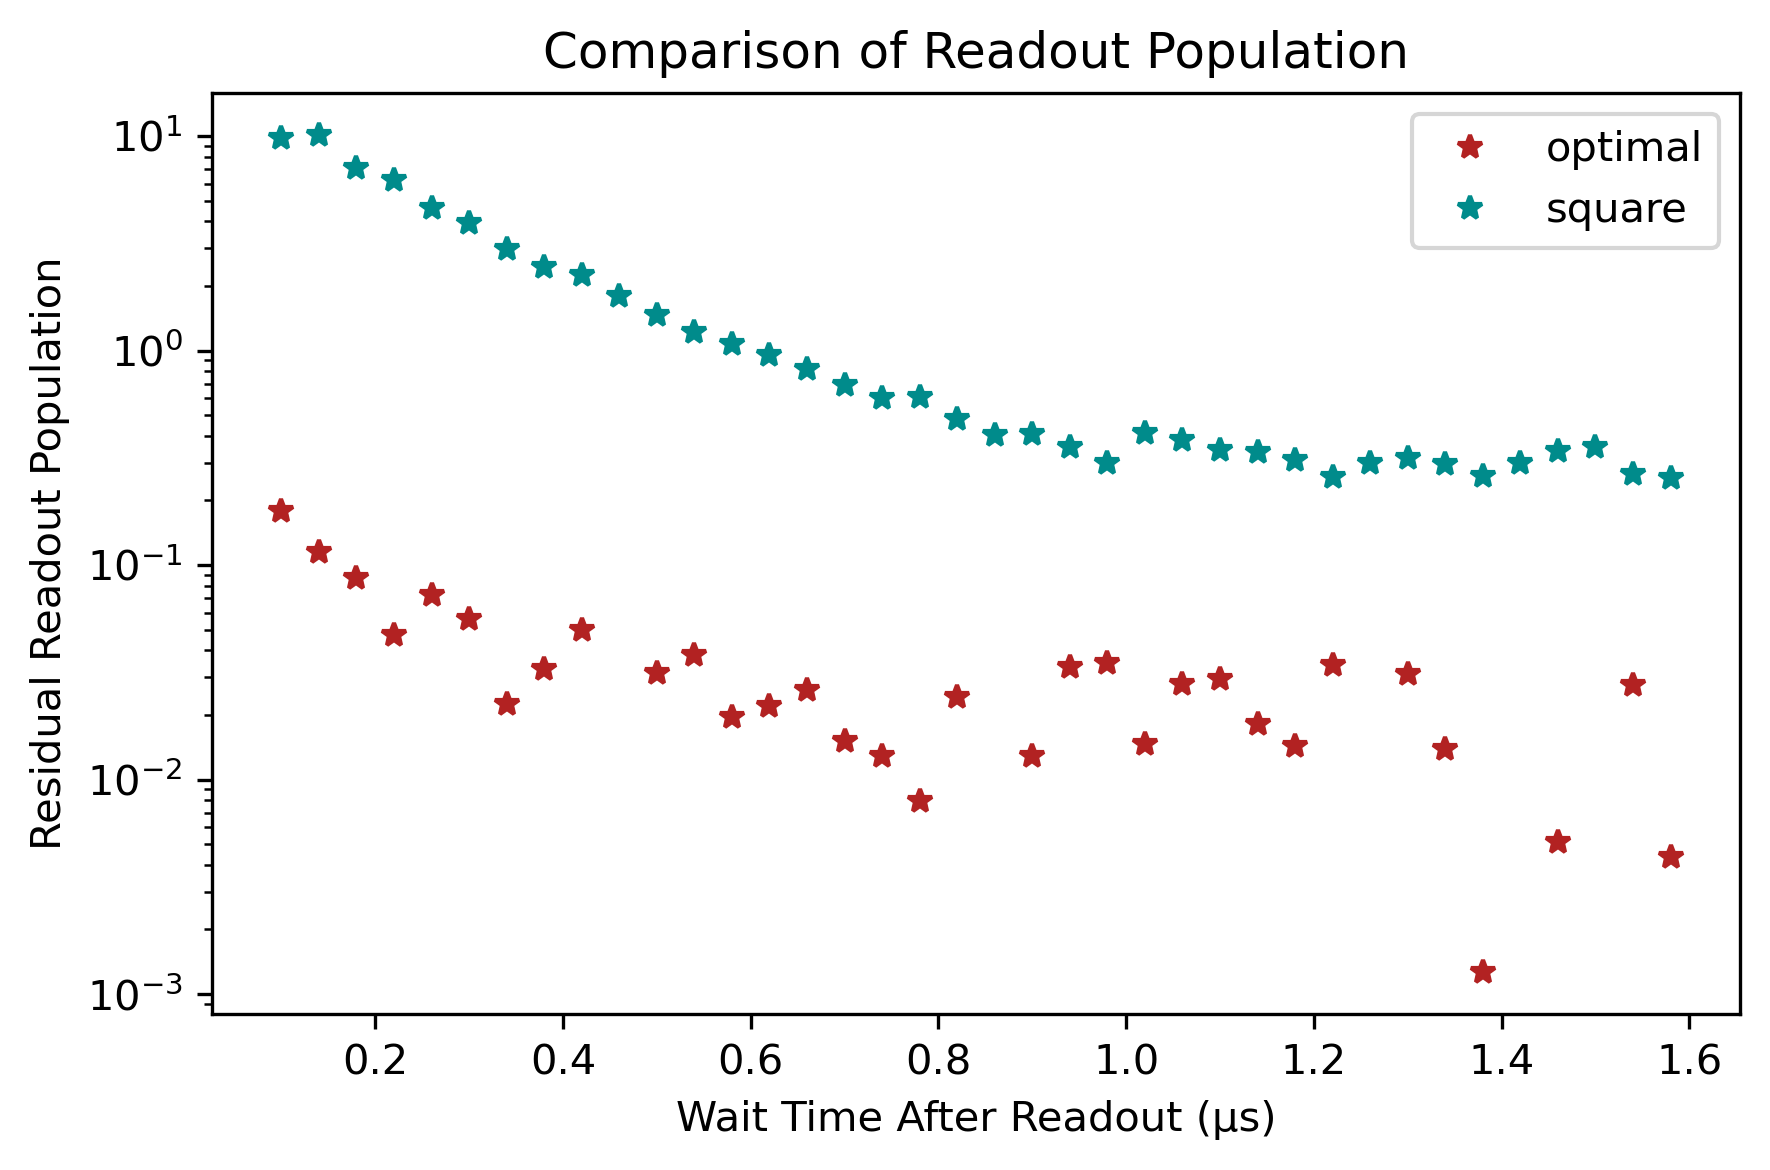

In [137]:
read_popt_opt = []
read_popt_error_opt = []
for j in range(len(wait_times)):
    y_data = i_cal_opt.iloc[j]
    x_data = ramsey_times
    popt, pcov = scipy.optimize.curve_fit(ramsfit, x_data, y_data)
    read_popt_opt.append(popt[0])
    read_popt_error_opt.append(np.sqrt(np.diag(pcov)[0]))
    
read_popt_square = []
read_popt_error_square = []
for j in range(len(wait_times)):
    y_data = i_cal_sq.iloc[j]
    x_data = ramsey_times
    popt, pcov = scipy.optimize.curve_fit(ramsfit, x_data[2:], y_data[2:])
    read_popt_square.append(popt[0])
    read_popt_error_square.append(np.sqrt(np.diag(pcov)[0]))


fig, ax1  = plt.subplots(dpi=300)
 
ax1.plot(wait_times*1e6, read_popt_opt, '*', color='firebrick', label='optimal')

ax1.plot(wait_times*1e6, read_popt_square, '*', color='darkcyan', label = 'square')
# ax2.tick_params(axis='y', labelcolor='darkcyan')

ax1.set_title('Comparison of Readout Population')
ax1.set_ylabel('Residual Readout Population')
ax1.set_xlabel('Wait Time After Readout (μs)')
# ax1.set_ylim(-.1, 1)
# ax2.set_ylim(-.1, 1)
plt.yscale('log')
plt.legend()
plt.tight_layout()
# plt.savefig('../plots/Readout_Popt_Comp_talk_full.pdf')
plt.show()

In [145]:
10*np.exp(-1.6/0.18)

0.0013791280933656194

[17.72802758  0.19170389  0.25202151] [0.6441008  0.00782116 0.06847254]


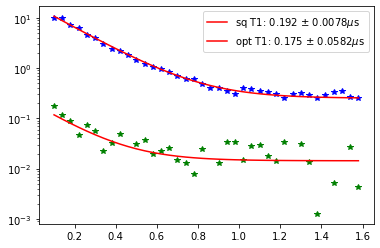

[0.18366301 0.17469616 0.01440297] [0.08260954 0.05822461 0.00342279]


In [146]:
y = np.array(read_popt_square)
x = np.array(wait_times)*1e6

plt.plot(x, y, 'b*')
popt, pcov = scipy.optimize.curve_fit(expfunc_baseline, x, y)
print(popt, np.sqrt(np.diag(pcov)))
plt.plot(x, expfunc_baseline(x, popt[0], popt[1], popt[2]), 'r-', 
         label=r'sq T1: %.3f $\pm$ %.4f$\mu$s'%(popt[1], np.sqrt(np.diag(pcov))[1]))
y = np.array(read_popt_opt)
x = np.array(wait_times)*1e6

plt.plot(x, y, 'g*')
popt, pcov = scipy.optimize.curve_fit(expfunc_baseline, x[2:], y[2:])
plt.plot(x, expfunc_baseline(x, popt[0], popt[1], popt[2]), 'r-', 
         label=r'opt T1: %.3f $\pm$ %.4f$\mu$s'%(popt[1], np.sqrt(np.diag(pcov))[1]))
plt.legend()
plt.yscale('log')
plt.show()
print(popt, np.sqrt(np.diag(pcov)))

0.003333333333333333 0.0007380739030881347
Chi:  0.3804 MHz
Kappa:  0.9149659090909091 MHz
Cavity Occupation 0.00142
Cavity temperature = 53.37698929287676 mK
Cavity temperature+ = 55.03127983687904 mK
Cavity temperature- = 51.37911894753762 mK


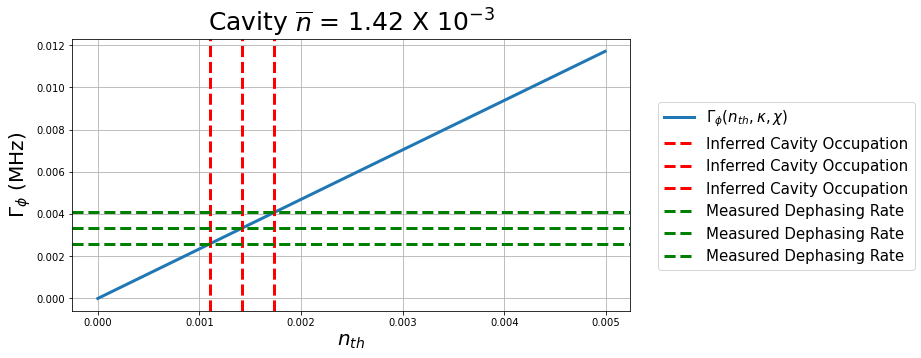

In [474]:
T2 = 120
T2err = 10
T1 = 100
T1err = 10

gph  = 1/(T2) - 1/(2*T1)
gpherr = sqrt( (1/(2*T1))**4*T1err**2 + (1/(T2))**4*T2err**2 )

print (gph, gpherr)

nu_r = 8.0517
Q = 8800.0
kappa = 2*pi*nu_r/Q*1e3

chi = 0.3804*2*pi

print ("Chi: ", chi/(2*pi), "MHz")
print ("Kappa: ", kappa/(2*pi), "MHz")

def temperature_cav(nu,mean_n):
    Kb = 1.38e-23
    h = 6e-34
    return h*nu/(Kb*log((1+mean_n)/mean_n))

def occupation_cav(nu,T):
    Kb = 1.38e-23
    h = 6e-34
    T = T*1e-3
    return 1/(exp(h*nu/(Kb*T))-1)


def dephasing(kappa,chi,nth):
    return kappa/2.0*real(sqrt((1+2*1j*chi/kappa)**2 + ((8*1j*chi*nth))/kappa)-1)

def freq_shift(kappa,chi,nth):
    return kappa/2.0*imag(sqrt((1+2*1j*chi/kappa)**2 + ((8*1j*chi*nth))/kappa))

figure(figsize=(10,5))
subplot(111)
n_th = arange(0.0, 0.005,0.00001)

plot(n_th, array([dephasing(kappa,chi,n) for n in n_th] ), label = '$\Gamma_{\phi}(n_{th}, \kappa, \chi)$', linewidth=3)

n_cav = n_th[argmin(abs(array([dephasing(kappa,chi,n) for n in n_th]) - gph))]
n_cav_pluserr = n_th[argmin(abs(array([dephasing(kappa,chi,n) for n in n_th]) - (gph+gpherr)))]
n_cav_negerr = n_th[argmin(abs(array([dephasing(kappa,chi,n) for n in n_th]) - (gph-gpherr)))]
print ("Cavity Occupation", n_cav)

axvline(n_cav,linestyle='dashed', label="Inferred Cavity Occupation",color='r', linewidth=3)
axvline(n_cav_pluserr,linestyle='dashed', label="Inferred Cavity Occupation",color='r', linewidth=3)
axvline(n_cav_negerr,linestyle='dashed', label="Inferred Cavity Occupation",color='r', linewidth=3)

axhline(gph,linestyle='dashed', label="Measured Dephasing Rate",color='g', linewidth=3)
axhline(gph+gpherr,linestyle='dashed', label="Measured Dephasing Rate",color='g', linewidth=3)
axhline(gph-gpherr,linestyle='dashed', label="Measured Dephasing Rate",color='g', linewidth=3)

ylabel('$\Gamma_{\phi}$ (MHz)', fontsize='20')
xlabel('$n_{th}$', fontsize='20')
title('Cavity $\overline{n}$ = %s X $10^{-3}$' %(n_cav*1e3), fontsize='25')
grid()
legend(loc=(1.05, 0.15),fontsize='15')
print ("Cavity temperature = %s mK"%(1e3*temperature_cav(nu_r*1e9,n_cav)))
print ("Cavity temperature+ = %s mK"%(1e3*temperature_cav(nu_r*1e9,n_cav_pluserr)))
print ("Cavity temperature- = %s mK"%(1e3*temperature_cav(nu_r*1e9,n_cav_negerr)))